<a href="https://colab.research.google.com/github/JiaruiTang/Shinkansen-Passenger-Satisfaction-Prediction/blob/master/MIT_Program_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This notebook was created by @Jiarui Tang.

# Shinkansen Travel Experience

This problem statement is based on the Shinkansen Bullet Train in Japan, and passengers' experience with that mode of travel.

**Goal:**

- The major goal of this project is to predict whether a passenger was satisfied or not considering his/her overall experience of travelling on the Shinkansen Bullet Train.
- The secondary goal is to determine the relative importance of each parameter with regard to their contribution to the passengers' overall travel experience.

**Dataset:**

The dataset contains a random sample of individuals who travelled on this train. The on-time performance of the trains along with passenger information is stored in **Traveldata**.

These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report labelled **Surveydata**.

In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in **Surveydata** under the variable labelled **`Overall_Experience`**.

The data has been split into two groups, training data and test data.

Test data containing the travel data and the survey data of passengers are provided in files named **Traveldata_test.csv** and **Surveydata_test.csv**. Variable **`Overall_Experience`** was not available in **Surveydata_test.csv**.

Both the test data and the train data are collected at the same time and belong to the same population.

In summary, below are the dataset files provided in folder:

- **Traveldata_train.csv**

- **Surveydata_train.csv**

- **Traveldata_test.csv**

- **Surveydata_test.csv**


In [ ]:
# Load basic packages
import pandas as pd
import numpy as np

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# Load missing data visualization package
#!pip install missingno
import missingno as mi

# Load stats model package
import statsmodels.api as sm

# Randomization Tool
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Hyperparameter Optimization
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Modeling
import lightgbm as lgbm
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Command to tell Python to actually display the graphs
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = (6.4, 4.8)

# Output in high quality.
%config InlineBackend.figure_format='retina'

# Display color palette
sns.color_palette(palette='Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

## Load Data

In [ ]:
# Read .csv training dataset
travel_train = pd.read_csv('/content/drive/MyDrive/DSML/Hackathon/Traveldata_train.csv')
survey_train = pd.read_csv('/content/drive/MyDrive/DSML/Hackathon/Surveydata_train.csv')

In [ ]:
# Read .csv test dataset
travel_test = pd.read_csv('/content/drive/MyDrive/DSML/Hackathon/Traveldata_test.csv')
survey_test = pd.read_csv('/content/drive/MyDrive/DSML/Hackathon/Surveydata_test.csv')

## Understand Data

### Understand Travel Data

In [ ]:
# Preview travel training dataset
travel_train.head()

ID  Gender   Customer_Type   Age      Type_Travel Travel_Class  \
0  98800001  Female  Loyal Customer  52.0              NaN     Business   
1  98800002    Male  Loyal Customer  48.0  Personal Travel          Eco   
2  98800003  Female  Loyal Customer  43.0  Business Travel     Business   
3  98800004  Female  Loyal Customer  44.0  Business Travel     Business   
4  98800005  Female  Loyal Customer  50.0  Business Travel     Business   

   Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  
0              272                      0.0                    5.0  
1             2200                      9.0                    0.0  
2             1061                     77.0                  119.0  
3              780                     13.0                   18.0  
4             1981                      0.0                    0.0

In [ ]:
# List all column names in the travel_train DataFrame
travel_train.columns

Index(['ID', 'Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'],
      dtype='object')

**Travel Data Dictionary:**

| Column Name              | Column Description                          | Column Value Examples                          |
|--------------------------|---------------------------------------------|------------------------------------------------|
| ID                       | The unique ID of the passenger              | Continuous values like 98800001, 98800002, etc.|
| Gender                   | The gender of the passenger                 | "Male<br>Female"                               |
| Customer_Type            | Loyalty type of the passenger               | "Loyal Customer<br>Disloyal Customer"          |
| Age                      | The age of the passenger                    | Continuous values like 48, 52, 9, etc.         |
| Type_Travel              | Purpose of travel for the passenger         | "Personal Travel<br>Business Travel"           |
| Travel_Class             | The train class that the passenger traveled in | "Business<br>Eco"                             |
| Travel_Distance          | The distance traveled by the passenger      | Continuous values like 272, 780, 853, etc.     |
| Departure_Delay_in_Mins  | The delay (in minutes) in train departure   | Continuous values like 9, 15, 13, etc.         |
| Arrival_Delay_in_Mins    | The delay (in minutes) in train arrival     | Continuous values like 0, 15, 18, etc.         |


In [ ]:
# Summarize the travel_train DataFrame
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


The following findings can be obtained from the summary above:

- **Dataset Size:** 94,379 entries with 9 columns.
- **Columns:** ID, Gender, Customer_Type, Age, Type_Travel, Travel_Class, Travel_Distance, Departure_Delay_in_Mins, and Arrival_Delay_in_Mins.
- **Categorical columns:** Gender, Customer_Type, Type_Travel, Travel_Class.
- **Numeric columns:** Age, Travel_Distance, Departure_Delay_in_Mins, Arrival_Delay_in_Mins.
- **Missing Values:** Present in 6 columns, including Gender, Customer_Type, Age, Type_Travel, Departure_Delay_in_Mins, and Arrival_Delay_in_Mins.

Next, we will implement a simple linear regression and create a scatter plot to analyze the correlation between arrival and departure delay times. This step will be beneficial for dealing with missing data in the following analysis.


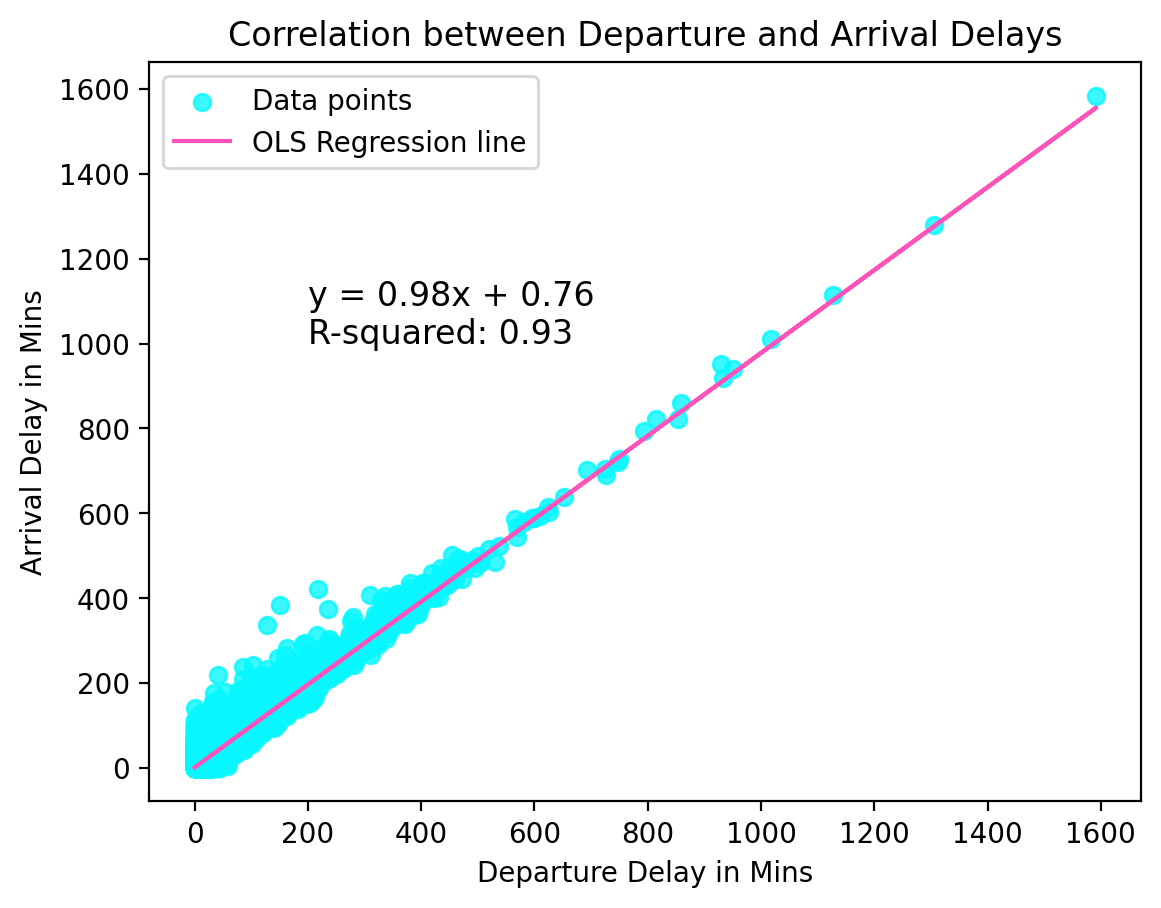

In [ ]:
# Generate scatter plot to explore correlation between arrival and departure delays.
# Create a separate DataFrame using data in Arrival_Delay_in_Mins and Departure_Delay_in_Mins
delay_time_df = pd.DataFrame({
    'Departure_Delay_in_Mins': travel_train['Departure_Delay_in_Mins'],
    'Arrival_Delay_in_Mins': travel_train['Arrival_Delay_in_Mins']
})

# Filtering out rows with missing values in delay_time_df DataFrame
filtered_data = delay_time_df.dropna()

# Fitting the linear regression model on the filtered data
X = sm.add_constant(filtered_data['Departure_Delay_in_Mins'])
Y = filtered_data['Arrival_Delay_in_Mins']
model = sm.OLS(Y, X).fit()

# Getting the fitted values from the model for plotting
fitted_values = model.fittedvalues

# Plotting
plt.scatter(filtered_data['Departure_Delay_in_Mins'], filtered_data['Arrival_Delay_in_Mins'], label='Data points',
            color='#08F7FE', alpha=0.8)
plt.plot(filtered_data['Departure_Delay_in_Mins'], fitted_values, label='OLS Regression line',
         color='#FE53BB')

# Add titles and labels
plt.title('Correlation between Departure and Arrival Delays')
plt.ylabel('Arrival Delay in Mins')
plt.xlabel('Departure Delay in Mins')

# Display the fitted regression equation and R-squared value
equation_ols = f"y = {model.params[1]:.2f}x + {model.params[0]:.2f}"
r_squared = f"R-squared: {model.rsquared:.2f}"

plt.legend()
plt.text(200, 1000, equation_ols + '\n' + r_squared, fontsize=12)

plt.show()

The estimated slope of the regression line is 0.98, very close to 1, which means the departure delay time can be highly predictable to the arrival delay time. It is reasonable to use the departure delay time as an evidence to impute the missing values in Arrival_Delay_in_Mins.

In [ ]:
# List categorical column names
travel_category_col = ['Gender','Customer_Type','Type_Travel','Travel_Class']
# Displaying the distributions of categorical data
for i in travel_category_col:
  print('column names: '+i)
  print(travel_train[i].value_counts())
  print('-------------------------------')

column names: Gender
Female    47815
Male      46487
Name: Gender, dtype: int64
-------------------------------
column names: Customer_Type
Loyal Customer       69823
Disloyal Customer    15605
Name: Customer_Type, dtype: int64
-------------------------------
column names: Type_Travel
Business Travel    58617
Personal Travel    26536
Name: Type_Travel, dtype: int64
-------------------------------
column names: Travel_Class
Eco         49342
Business    45037
Name: Travel_Class, dtype: int64
-------------------------------


The distributions of Customer_Type and Type_Travel are very imbalanced.


In [ ]:
# Verify all passenger IDs are unique to prevent duplicate data issues.
len(np.unique(travel_train['ID']))

94379

The number of unique IDs is the same as the number of entries in the dataset. Therefore, all passenger IDs in the dataset are unique without duplicates.

Next, check the distributions of numeric variables, Age, Travel_Distance, Departure_Delay_in_Mins and Arrival_Delay_in_Mins.

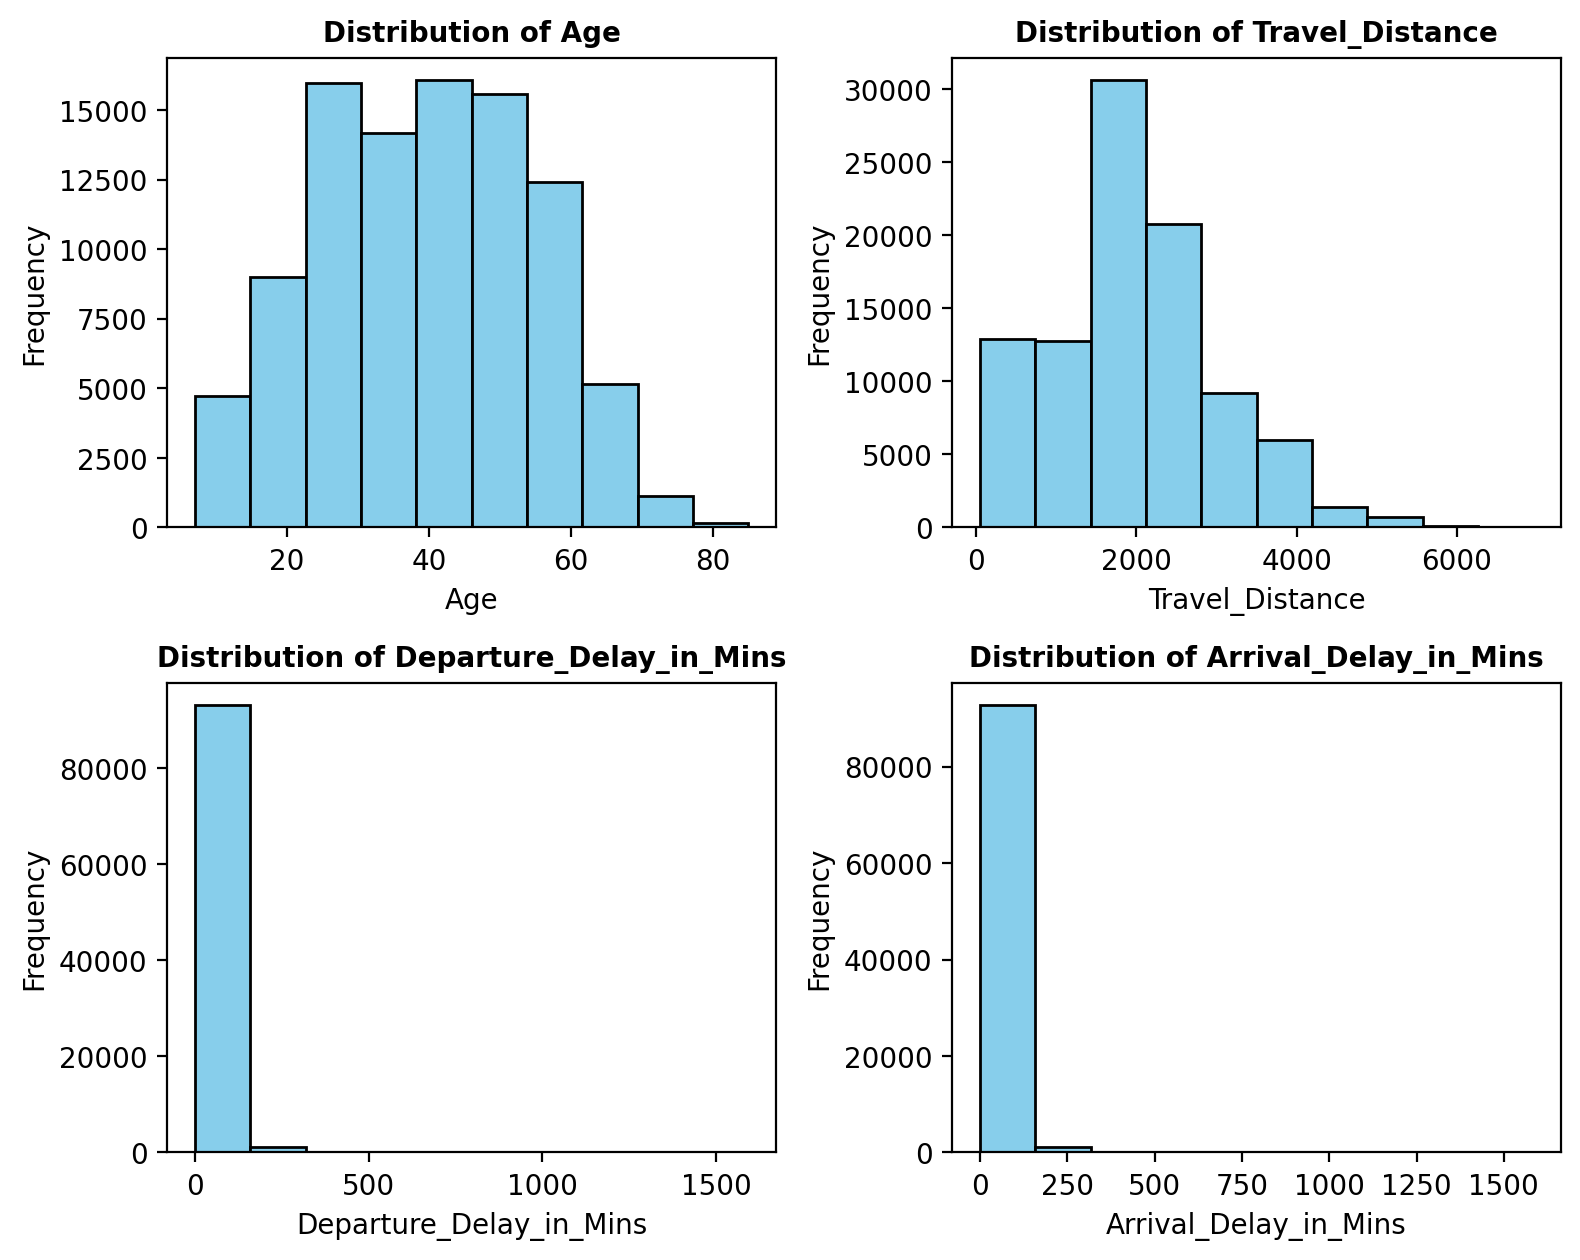

In [ ]:
# List numeric column names
travel_numeric_col = ['Age','Travel_Distance','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']

# Plotting histograms for all numeric columns
fig, axes = plt.subplots(2, 2, figsize=(8, 6.4))  # Creating a 2x2 subplot

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the numeric columns and create a histogram for each
for i, col in enumerate(travel_numeric_col):
    axes[i].hist(travel_train[col], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=10, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Both histograms of Departure_Delay_in_Mins and Arrival_Delay_in_Mins show a large concentration of flights with delay time close to 0 minutes, while there exist a few extreme delays between 800 and 1600 minutes. These outliers may need particular attention in further analysis.

### Understand Survey Data

In [ ]:
# Preview survey training dataset
survey_train.head()

ID  Overall_Experience       Seat_Comfort Seat_Class  \
0  98800001                   0  Needs Improvement  Green Car   
1  98800002                   0               Poor   Ordinary   
2  98800003                   1  Needs Improvement  Green Car   
3  98800004                   0         Acceptable   Ordinary   
4  98800005                   1         Acceptable   Ordinary   

  Arrival_Time_Convenient           Catering  Platform_Location  \
0               Excellent          Excellent    Very Convenient   
1               Excellent               Poor  Needs Improvement   
2       Needs Improvement  Needs Improvement  Needs Improvement   
3       Needs Improvement                NaN  Needs Improvement   
4              Acceptable         Acceptable         Manageable   

  Onboard_Wifi_Service Onboard_Entertainment Online_Support  \
0                 Good     Needs Improvement     Acceptable   
1                 Good                  Poor           Good   
2    Needs Improvement                  Good      Excellent   
3           Acceptable     Needs Improvement     Acceptable   
4    Needs Improvement                  Good      Excellent   

  Ease_of_Online_Booking    Onboard_Service            Legroom  \
0      Needs Improvement  Needs Improvement         Acceptable   
1                   Good          Excellent  Needs Improvement   
2              Excellent          Excellent          Excellent   
3             Acceptable         Acceptable         Acceptable   
4                   Good               Good               Good   

    Baggage_Handling    CheckIn_Service        Cleanliness Online_Boarding  
0  Needs Improvement               Good  Needs Improvement            Poor  
1               Poor  Needs Improvement               Good            Good  
2          Excellent               Good          Excellent       Excellent  
3         Acceptable               Good         Acceptable      Acceptable  
4               Good               Good               Good            Good

In [ ]:
# List all column names in the travel_train DataFrame
survey_train.columns

Index(['ID', 'Overall_Experience', 'Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
       'Online_Boarding'],
      dtype='object')

**Survey Data Dictionary:**

| Column Name           | Column Description                                                                 | Column Value Examples                                 |
|-----------------------|------------------------------------------------------------------------------------|------------------------------------------------------|
| ID                    | The unique ID of the passenger                                                     | Continuous values like 98800001, 98800002, etc.       |
| Platform_Location     | How convenient the location of the platform is for the passenger                   | Very Inconvenient to Very Convenient                  |
| Seat_Class            | The type of seat class in the train. Green Car seats are more spacious and comfortable than ordinary seats. On the Shinkansen train, Green Car has four seats per row, compared to five in the ordinary car. | Ordinary, Green Car                                   |
| Overall_Experience    | The overall experience of the passenger                                            | 1 - Satisfied, 0 - Not Satisfied                     |
| Seat_Comfort          | The comfort level of the seat for the passenger                                    | Extremely Poor to Excellent                          |
| Arrival_Time_Convenient | How convenient the arrival time of the train is for the passenger                | Extremely Poor to Excellent                          |
| Catering              | How convenient the catering service is for the passenger                           | Extremely Poor to Excellent                          |
| Onboard_Wifi_Service  | The quality of the onboard Wi-Fi service for the passenger                         | Extremely Poor to Excellent                          |
| Onboard_Entertainment | The quality of the onboard entertainment for the passenger                         | Extremely Poor to Excellent                          |
| Online_Support        | The quality of the online support for the passenger                                | Extremely Poor to Excellent                          |
| Ease_of_Online_Booking | The ease of online booking for the passenger                                      | Extremely Poor to Excellent                          |
| Onboard_Service       | The quality of the onboard service for the passenger                               | Extremely Poor to Excellent                          |
| Legroom               | Legroom is the term for "seat pitch", the distance from a point on one seat to the same point on the seat in front. Describes the convenience of the legroom for the passenger. | Extremely Poor to Excellent                          |
| Baggage_Handling      | The convenience of baggage handling for the passenger                              | Extremely Poor to Excellent                          |
| CheckIn_Service       | The convenience of the check-in service for the passenger                          | Extremely Poor to Excellent                          |
| Cleanliness           | The passenger's view of the cleanliness of the service                             | Extremely Poor to Excellent                          |
| Online_Boarding       | The convenience of the online boarding process for the passenger                   | Extremely Poor to Excellent                          |


From the data dictionary, all features from Platform_Location to Online_Boarding are categorical.

In [ ]:
# Summarize the travel_train DataFrame
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

The following findings can be obtained from the summary above:

- **Dataset Size:** 94,379 entries with 17 columns.
- **Columns:** ID, Gender, Customer_Type, Age, Type_Travel, Travel_Class, Travel_Distance, Departure_Delay_in_Mins, and Arrival_Delay_in_Mins.
- **Columns with object data type:** Seat_Comfort, Seat_Class, Arrival_Time_Convenient, Catering, Platform_Location, Onboard_Wifi_Service, Onboard_Entertainment, Online_Support, Ease_of_Online_Booking, Onboard_Service, Legroom, Baggage_Handling, CheckIn_Service, Cleanliness, Online_Boarding.
- **Columns with int64 data type:** ID, Overall_Experience.
- **Missing Values:** Present in all 15 categorical columns.

In [ ]:
# Count the frequency of each unique value in the 'Overall_Experience'
survey_train['Overall_Experience'].value_counts()

1    51593
0    42786
Name: Overall_Experience, dtype: int64

In [ ]:
# List categorical column names
survey_category_col = ['Seat_Comfort','Seat_Class','Arrival_Time_Convenient',
                       'Catering','Platform_Location','Onboard_Wifi_Service',
                       'Onboard_Entertainment','Online_Support','Ease_of_Online_Booking',
                       'Onboard_Service','Legroom','Baggage_Handling','CheckIn_Service',
                       'Cleanliness','Online_Boarding']
# Display the distributions of categorical data
for i in survey_category_col:
  print('column names: '+i)
  print(survey_train[i].value_counts())
  print('-------------------------------')

column names: Seat_Comfort
Acceptable           21158
Needs Improvement    20946
Good                 20595
Poor                 15185
Excellent            12971
Extremely Poor        3463
Name: Seat_Comfort, dtype: int64
-------------------------------
column names: Seat_Class
Green Car    47435
Ordinary     46944
Name: Seat_Class, dtype: int64
-------------------------------
column names: Arrival_Time_Convenient
Good                 19574
Excellent            17684
Acceptable           15177
Needs Improvement    14990
Poor                 13692
Extremely Poor        4332
Name: Arrival_Time_Convenient, dtype: int64
-------------------------------
column names: Catering
Acceptable           18468
Needs Improvement    17978
Good                 17969
Poor                 13858
Excellent            13455
Extremely Poor        3910
Name: Catering, dtype: int64
-------------------------------
column names: Platform_Location
Manageable           24173
Convenient           21912
Needs Improv

**Findings:**

- `Seat Class` is highly balanced, with the count of 'Green Car' and 'Ordinary' classes almost identical.
- Columns `Seat Comfort`, `Arrival Time Convenient`, `Catering`, `Onboard_Entertainment`, and `Baggage_Handling`  are moderately balanced.
- Columns `Platform_Location`, `Onboard_Wifi_Service`, `Online_Support`, `Ease_of_Online_Booking`, `Onboard_Service`, `Legroom`, `CheckIn_Service`, `Cleanliness`, `Online_Boarding` are extremely imbalanced.
- Overall, passengers tend to give more positive ratings to their experience.


## Clean Data

In this part, I will first merge the survey and travel data to a single DataFrame. Next, it is important and necessary to deal with the large amount of null values. In addition, I will convert the values in categorical columns into dummy variables, preparing for further analysis.

In [ ]:
# Merge Survey and Travel data
train_data_merged = pd.merge(travel_train, survey_train, on='ID')
train_data_merged.head()

ID  Gender   Customer_Type   Age      Type_Travel Travel_Class  \
0  98800001  Female  Loyal Customer  52.0              NaN     Business   
1  98800002    Male  Loyal Customer  48.0  Personal Travel          Eco   
2  98800003  Female  Loyal Customer  43.0  Business Travel     Business   
3  98800004  Female  Loyal Customer  44.0  Business Travel     Business   
4  98800005  Female  Loyal Customer  50.0  Business Travel     Business   

   Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
0              272                      0.0                    5.0   
1             2200                      9.0                    0.0   
2             1061                     77.0                  119.0   
3              780                     13.0                   18.0   
4             1981                      0.0                    0.0   

   Overall_Experience  ... Onboard_Wifi_Service Onboard_Entertainment  \
0                   0  ...                 Good     Needs Improvement   
1                   0  ...                 Good                  Poor   
2                   1  ...    Needs Improvement                  Good   
3                   0  ...           Acceptable     Needs Improvement   
4                   1  ...    Needs Improvement                  Good   

  Online_Support Ease_of_Online_Booking    Onboard_Service            Legroom  \
0     Acceptable      Needs Improvement  Needs Improvement         Acceptable   
1           Good                   Good          Excellent  Needs Improvement   
2      Excellent              Excellent          Excellent          Excellent   
3     Acceptable             Acceptable         Acceptable         Acceptable   
4      Excellent                   Good               Good               Good   

    Baggage_Handling    CheckIn_Service        Cleanliness Online_Boarding  
0  Needs Improvement               Good  Needs Improvement            Poor  
1               Poor  Needs Improvement               Good            Good  
2          Excellent               Good          Excellent       Excellent  
3         Acceptable               Good         Acceptable      Acceptable  
4               Good               Good               Good            Good  

[5 rows x 25 columns]

In [ ]:
# List all the collumn names in merged data
train_data_merged.columns

Index(['ID', 'Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins',
       'Overall_Experience', 'Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
       'Online_Boarding'],
      dtype='object')

In [ ]:
# Summarize the merged training data
train_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

### Understand Missing Data

In [ ]:
# Display the numbers and percentages of missing data in each column
pd.concat([train_data_merged.isnull().sum(),train_data_merged.isnull().sum()/train_data_merged.shape[0]*100],axis=1,keys=['Number','Pct'])

Number       Pct
ID                            0  0.000000
Gender                       77  0.081586
Customer_Type              8951  9.484101
Age                          33  0.034965
Type_Travel                9226  9.775480
Travel_Class                  0  0.000000
Travel_Distance               0  0.000000
Departure_Delay_in_Mins      57  0.060395
Arrival_Delay_in_Mins       357  0.378262
Overall_Experience            0  0.000000
Seat_Comfort                 61  0.064633
Seat_Class                    0  0.000000
Arrival_Time_Convenient    8930  9.461851
Catering                   8741  9.261594
Platform_Location            30  0.031787
Onboard_Wifi_Service         30  0.031787
Onboard_Entertainment        18  0.019072
Online_Support               91  0.096420
Ease_of_Online_Booking       73  0.077348
Onboard_Service            7601  8.053698
Legroom                      90  0.095360
Baggage_Handling            142  0.150457
CheckIn_Service              77  0.081586
Cleanliness                   6  0.006357
Online_Boarding               6  0.006357

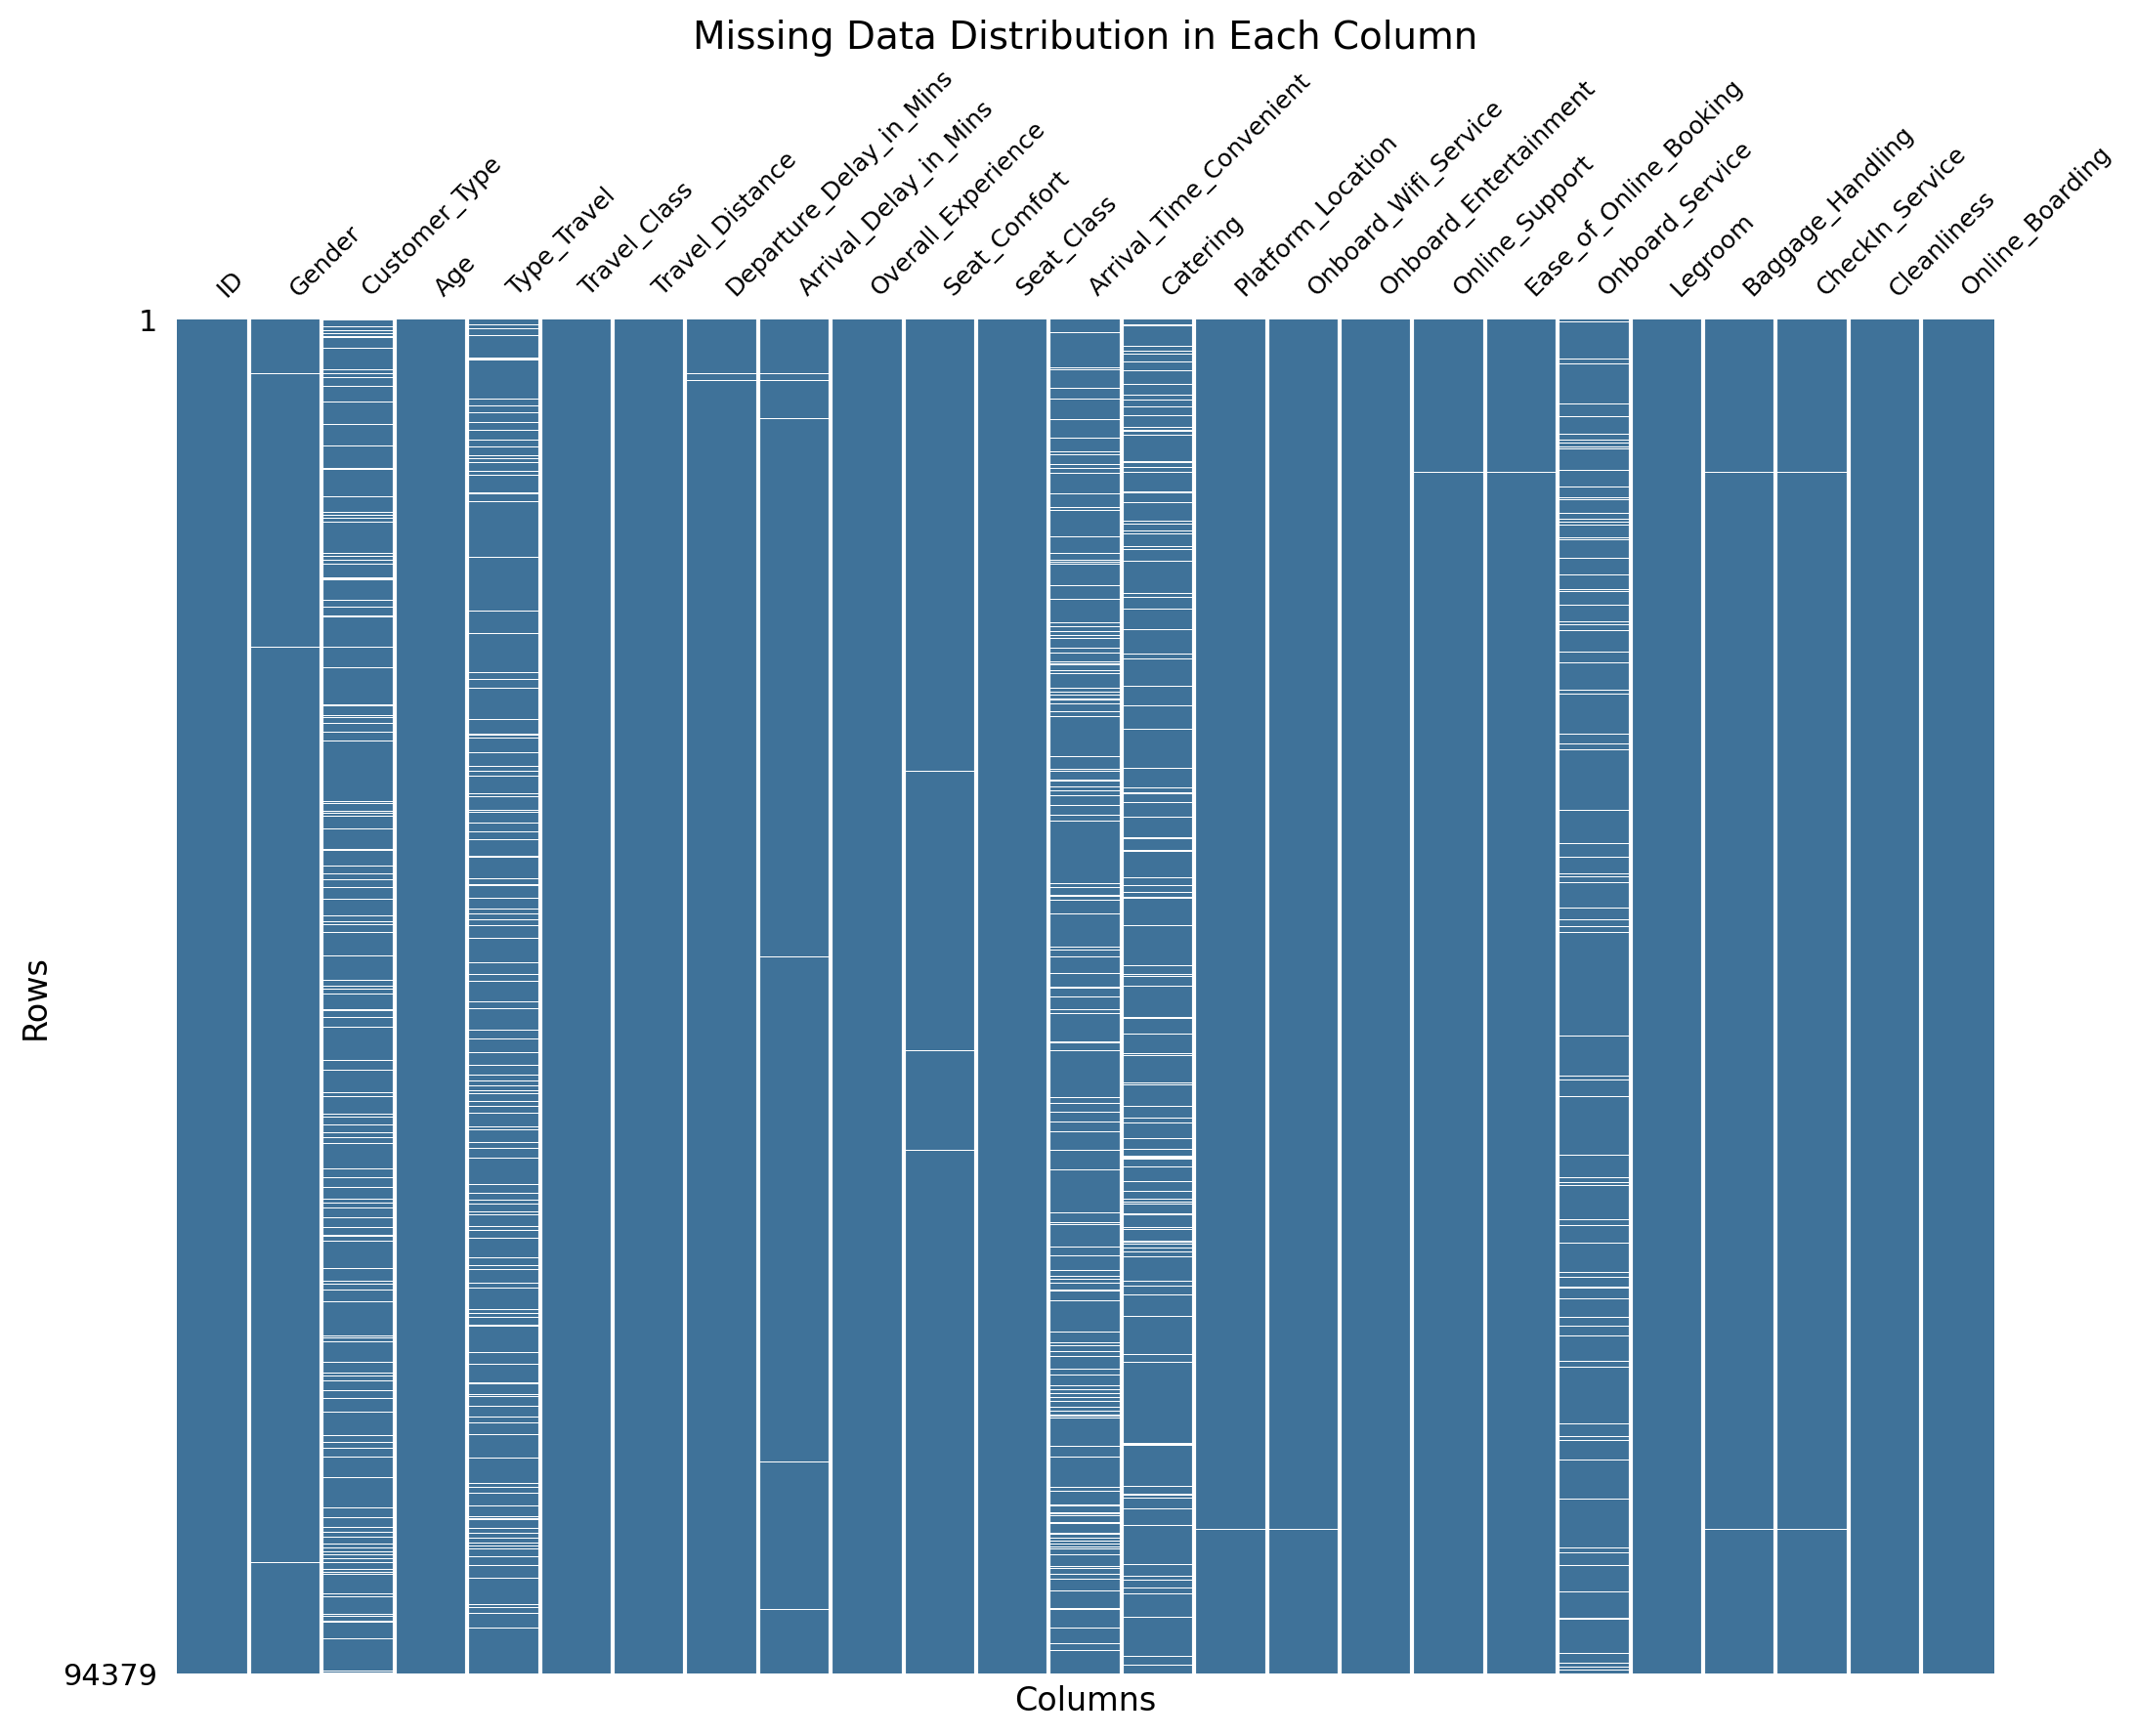

In [ ]:
# Visualize distributions of missing data in each column
mi.matrix(train_data_merged, sparkline=False, color=(0.25, 0.45, 0.6), figsize=(12, 9), fontsize=9)
# Add title and modify font size
plt.title('Missing Data Distribution in Each Column', fontsize=14)
# Customize x and y axis labels
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
# Rotate x-axis labels
plt.xticks(rotation=45)
# Eliminate top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Deal with Missing Data

In [ ]:
# get a full list of categorical column names
category_col = travel_category_col+survey_category_col
category_col

['Gender',
 'Customer_Type',
 'Type_Travel',
 'Travel_Class',
 'Seat_Comfort',
 'Seat_Class',
 'Arrival_Time_Convenient',
 'Catering',
 'Platform_Location',
 'Onboard_Wifi_Service',
 'Onboard_Entertainment',
 'Online_Support',
 'Ease_of_Online_Booking',
 'Onboard_Service',
 'Legroom',
 'Baggage_Handling',
 'CheckIn_Service',
 'Cleanliness',
 'Online_Boarding']

In [ ]:
# Deep copy train_data_merged DataFrame to train_data
train_data = train_data_merged.copy(deep=True)

In [ ]:
# Print the most frequent value and impute missing values with the mode of each column
for i in category_col:
  print("Column name: "+i)
  print("Most frequent value: "+train_data[i].mode()[0])
  train_data[i] = train_data[i].fillna(train_data[i].mode()[0])

Column name: Gender
Most frequent value: Female
Column name: Customer_Type
Most frequent value: Loyal Customer
Column name: Type_Travel
Most frequent value: Business Travel
Column name: Travel_Class
Most frequent value: Eco
Column name: Seat_Comfort
Most frequent value: Acceptable
Column name: Seat_Class
Most frequent value: Green Car
Column name: Arrival_Time_Convenient
Most frequent value: Good
Column name: Catering
Most frequent value: Acceptable
Column name: Platform_Location
Most frequent value: Manageable
Column name: Onboard_Wifi_Service
Most frequent value: Good
Column name: Onboard_Entertainment
Most frequent value: Good
Column name: Online_Support
Most frequent value: Good
Column name: Ease_of_Online_Booking
Most frequent value: Good
Column name: Onboard_Service
Most frequent value: Good
Column name: Legroom
Most frequent value: Good
Column name: Baggage_Handling
Most frequent value: Good
Column name: CheckIn_Service
Most frequent value: Good
Column name: Cleanliness
Most fre

In [ ]:
# Impute missing values in 'Age' with the median age
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

In [ ]:
# Fill missing values in Departure_Delay_in_Mins with the median
train_data['Departure_Delay_in_Mins'] = train_data['Departure_Delay_in_Mins'].fillna(train_data['Departure_Delay_in_Mins'].median())
# For 'Arrival_Delay_in_Mins', impute missing values using the corresponding 'Departure_Delay_in_Mins' values
train_data['Arrival_Delay_in_Mins'] = train_data['Arrival_Delay_in_Mins'].fillna(train_data['Departure_Delay_in_Mins'])

In [ ]:
# Check the numbers and percentages of missing data in each column after imputation
pd.concat([train_data.isnull().sum(),train_data.isnull().sum()/train_data.shape[0]*100], axis=1, keys=['Number','Pct'])

Number  Pct
ID                            0  0.0
Gender                        0  0.0
Customer_Type                 0  0.0
Age                           0  0.0
Type_Travel                   0  0.0
Travel_Class                  0  0.0
Travel_Distance               0  0.0
Departure_Delay_in_Mins       0  0.0
Arrival_Delay_in_Mins         0  0.0
Overall_Experience            0  0.0
Seat_Comfort                  0  0.0
Seat_Class                    0  0.0
Arrival_Time_Convenient       0  0.0
Catering                      0  0.0
Platform_Location             0  0.0
Onboard_Wifi_Service          0  0.0
Onboard_Entertainment         0  0.0
Online_Support                0  0.0
Ease_of_Online_Booking        0  0.0
Onboard_Service               0  0.0
Legroom                       0  0.0
Baggage_Handling              0  0.0
CheckIn_Service               0  0.0
Cleanliness                   0  0.0
Online_Boarding               0  0.0

In [ ]:
# Set 'ID' as the index of the dataframe and stored the dataframe in train, to uniquely identify each row.
train = train_data.set_index("ID")
# Convert categorical column values into dummy variables
train = pd.get_dummies(train, columns = category_col)
# Display the first few rows of the dataframe after creating dummy variables
train.head()

Age  Travel_Distance  Departure_Delay_in_Mins  \
ID                                                         
98800001  52.0              272                      0.0   
98800002  48.0             2200                      9.0   
98800003  43.0             1061                     77.0   
98800004  44.0              780                     13.0   
98800005  50.0             1981                      0.0   

          Arrival_Delay_in_Mins  Overall_Experience  Gender_Female  \
ID                                                                   
98800001                    5.0                   0              1   
98800002                    0.0                   0              0   
98800003                  119.0                   1              1   
98800004                   18.0                   0              1   
98800005                    0.0                   1              1   

          Gender_Male  Customer_Type_Disloyal Customer  \
ID                                                       
98800001            0                                0   
98800002            1                                0   
98800003            0                                0   
98800004            0                                0   
98800005            0                                0   

          Customer_Type_Loyal Customer  Type_Travel_Business Travel  ...  \
ID                                                                   ...   
98800001                             1                            1  ...   
98800002                             1                            0  ...   
98800003                             1                            1  ...   
98800004                             1                            1  ...   
98800005                             1                            1  ...   

          Cleanliness_Extremely Poor  Cleanliness_Good  \
ID                                                       
98800001                           0                 0   
98800002                           0                 1   
98800003                           0                 0   
98800004                           0                 0   
98800005                           0                 1   

          Cleanliness_Needs Improvement  Cleanliness_Poor  \
ID                                                          
98800001                              1                 0   
98800002                              0                 0   
98800003                              0                 0   
98800004                              0                 0   
98800005                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
98800001                           0                          0   
98800002                           0                          0   
98800003                           0                          1   
98800004                           1                          0   
98800005                           0                          0   

          Online_Boarding_Extremely Poor  Online_Boarding_Good  \
ID                                                               
98800001                               0                     0   
98800002                               0                     1   
98800003                               0                     0   
98800004                               0                     0   
98800005                               0                     1   

          Online_Boarding_Needs Improvement  Online_Boarding_Poor  
ID                                                                 
98800001                                  0                     1  
98800002                                  0                     0  
98800003                                  0                     0  
98800004                                  0        

In [ ]:
# Set 'ID' as the index and stored the DataFrame in train_no_dummy
train_no_dummy = train_data.set_index("ID")

## Exploratory Data Analysis

In this section, we will first analyze the three numeric columns, `Age`, `Travel_Distance`, `Departure_Delay_in_Mins`, and `Arrival_Delay_in_Mins`, including their distributions after data cleaning and their relationships with the outcome, `Overall_Experience`.

### Explore Distribution and Relationships of Numerical Variables

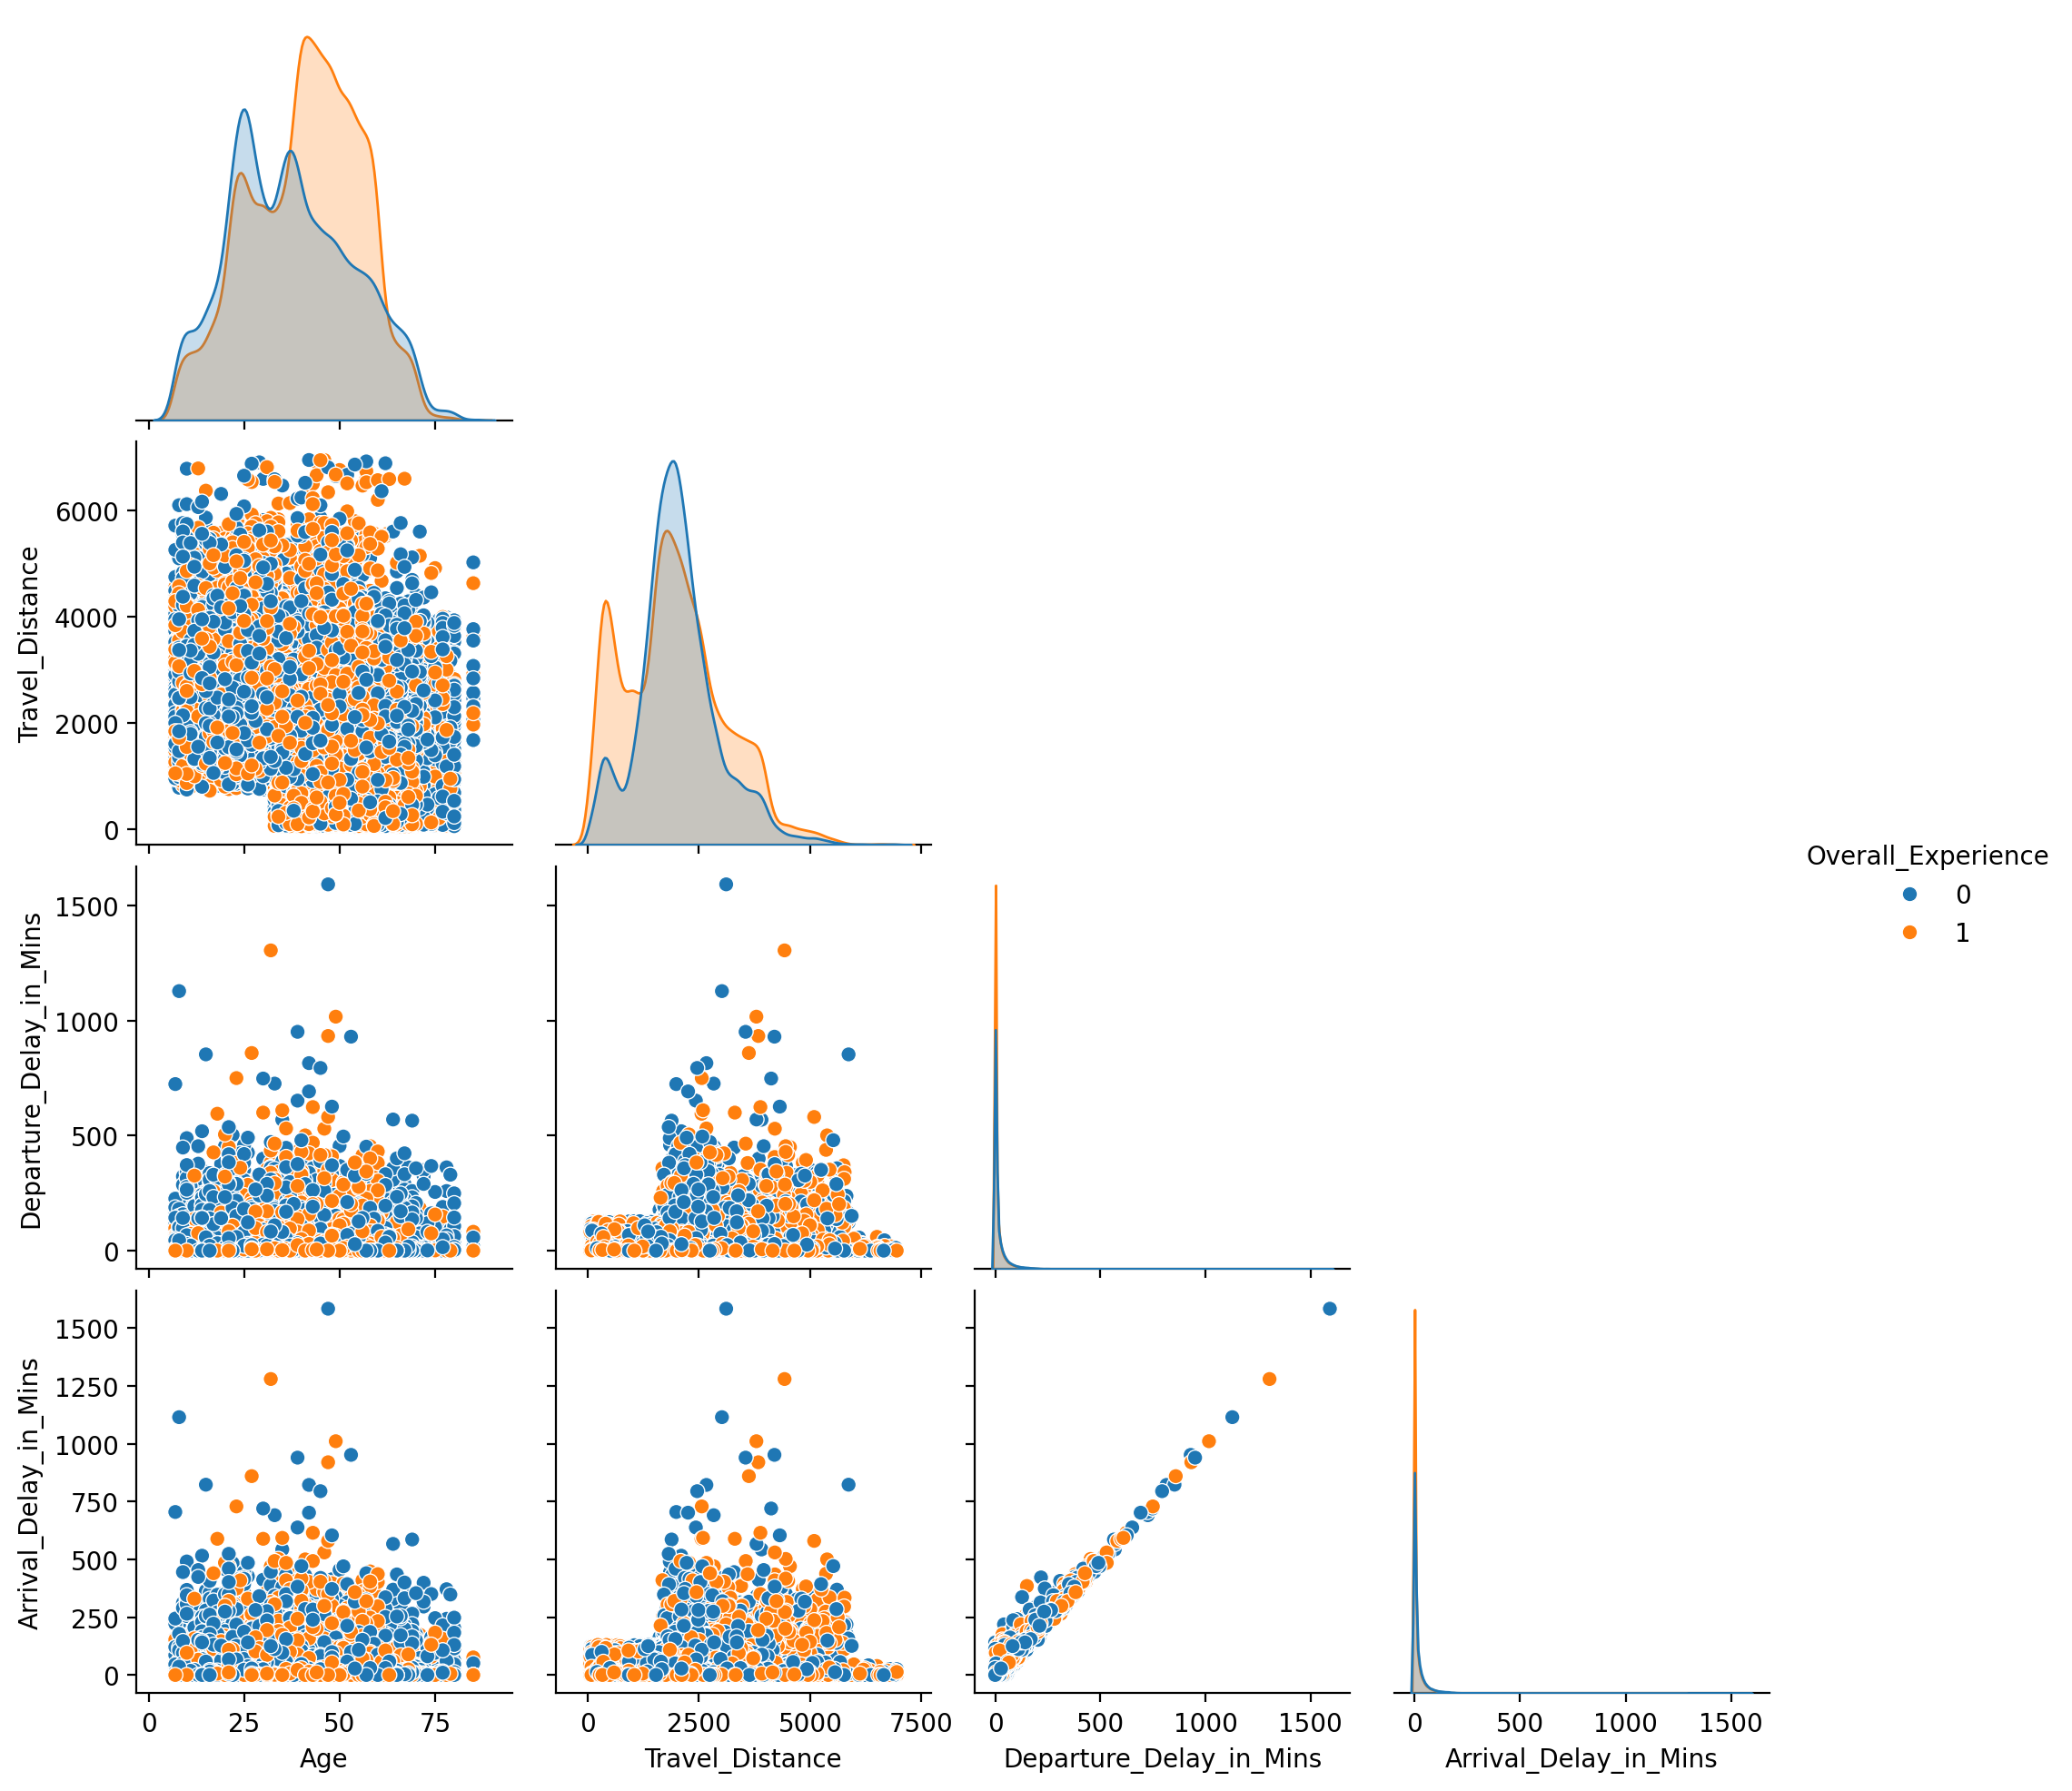

In [ ]:
# Generate a pair plot of numerical variables, colored by 'Overall_Experience'
sns.pairplot(data=train_no_dummy, vars=['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'],
             hue='Overall_Experience', corner=True)

**Findings:**

- The number of satisfied overall experiences is more than that of unsatisfactory experiences.
- The average age of passengers with unsatisfactory experiences is younger.
- The average travel distance of passengers younger than 30 years old is longer than those older.
- For travels with shorter distance (lower than 1250 miles) or extremely long distance (more than 2500 miles), passengers had higher chance of a satisfied experience.

### Explore Distributions and Relationships of Categorical Variables

Next, we will visualize the distributions of cateogrical variables and their relationships with `Overall_Experience`.

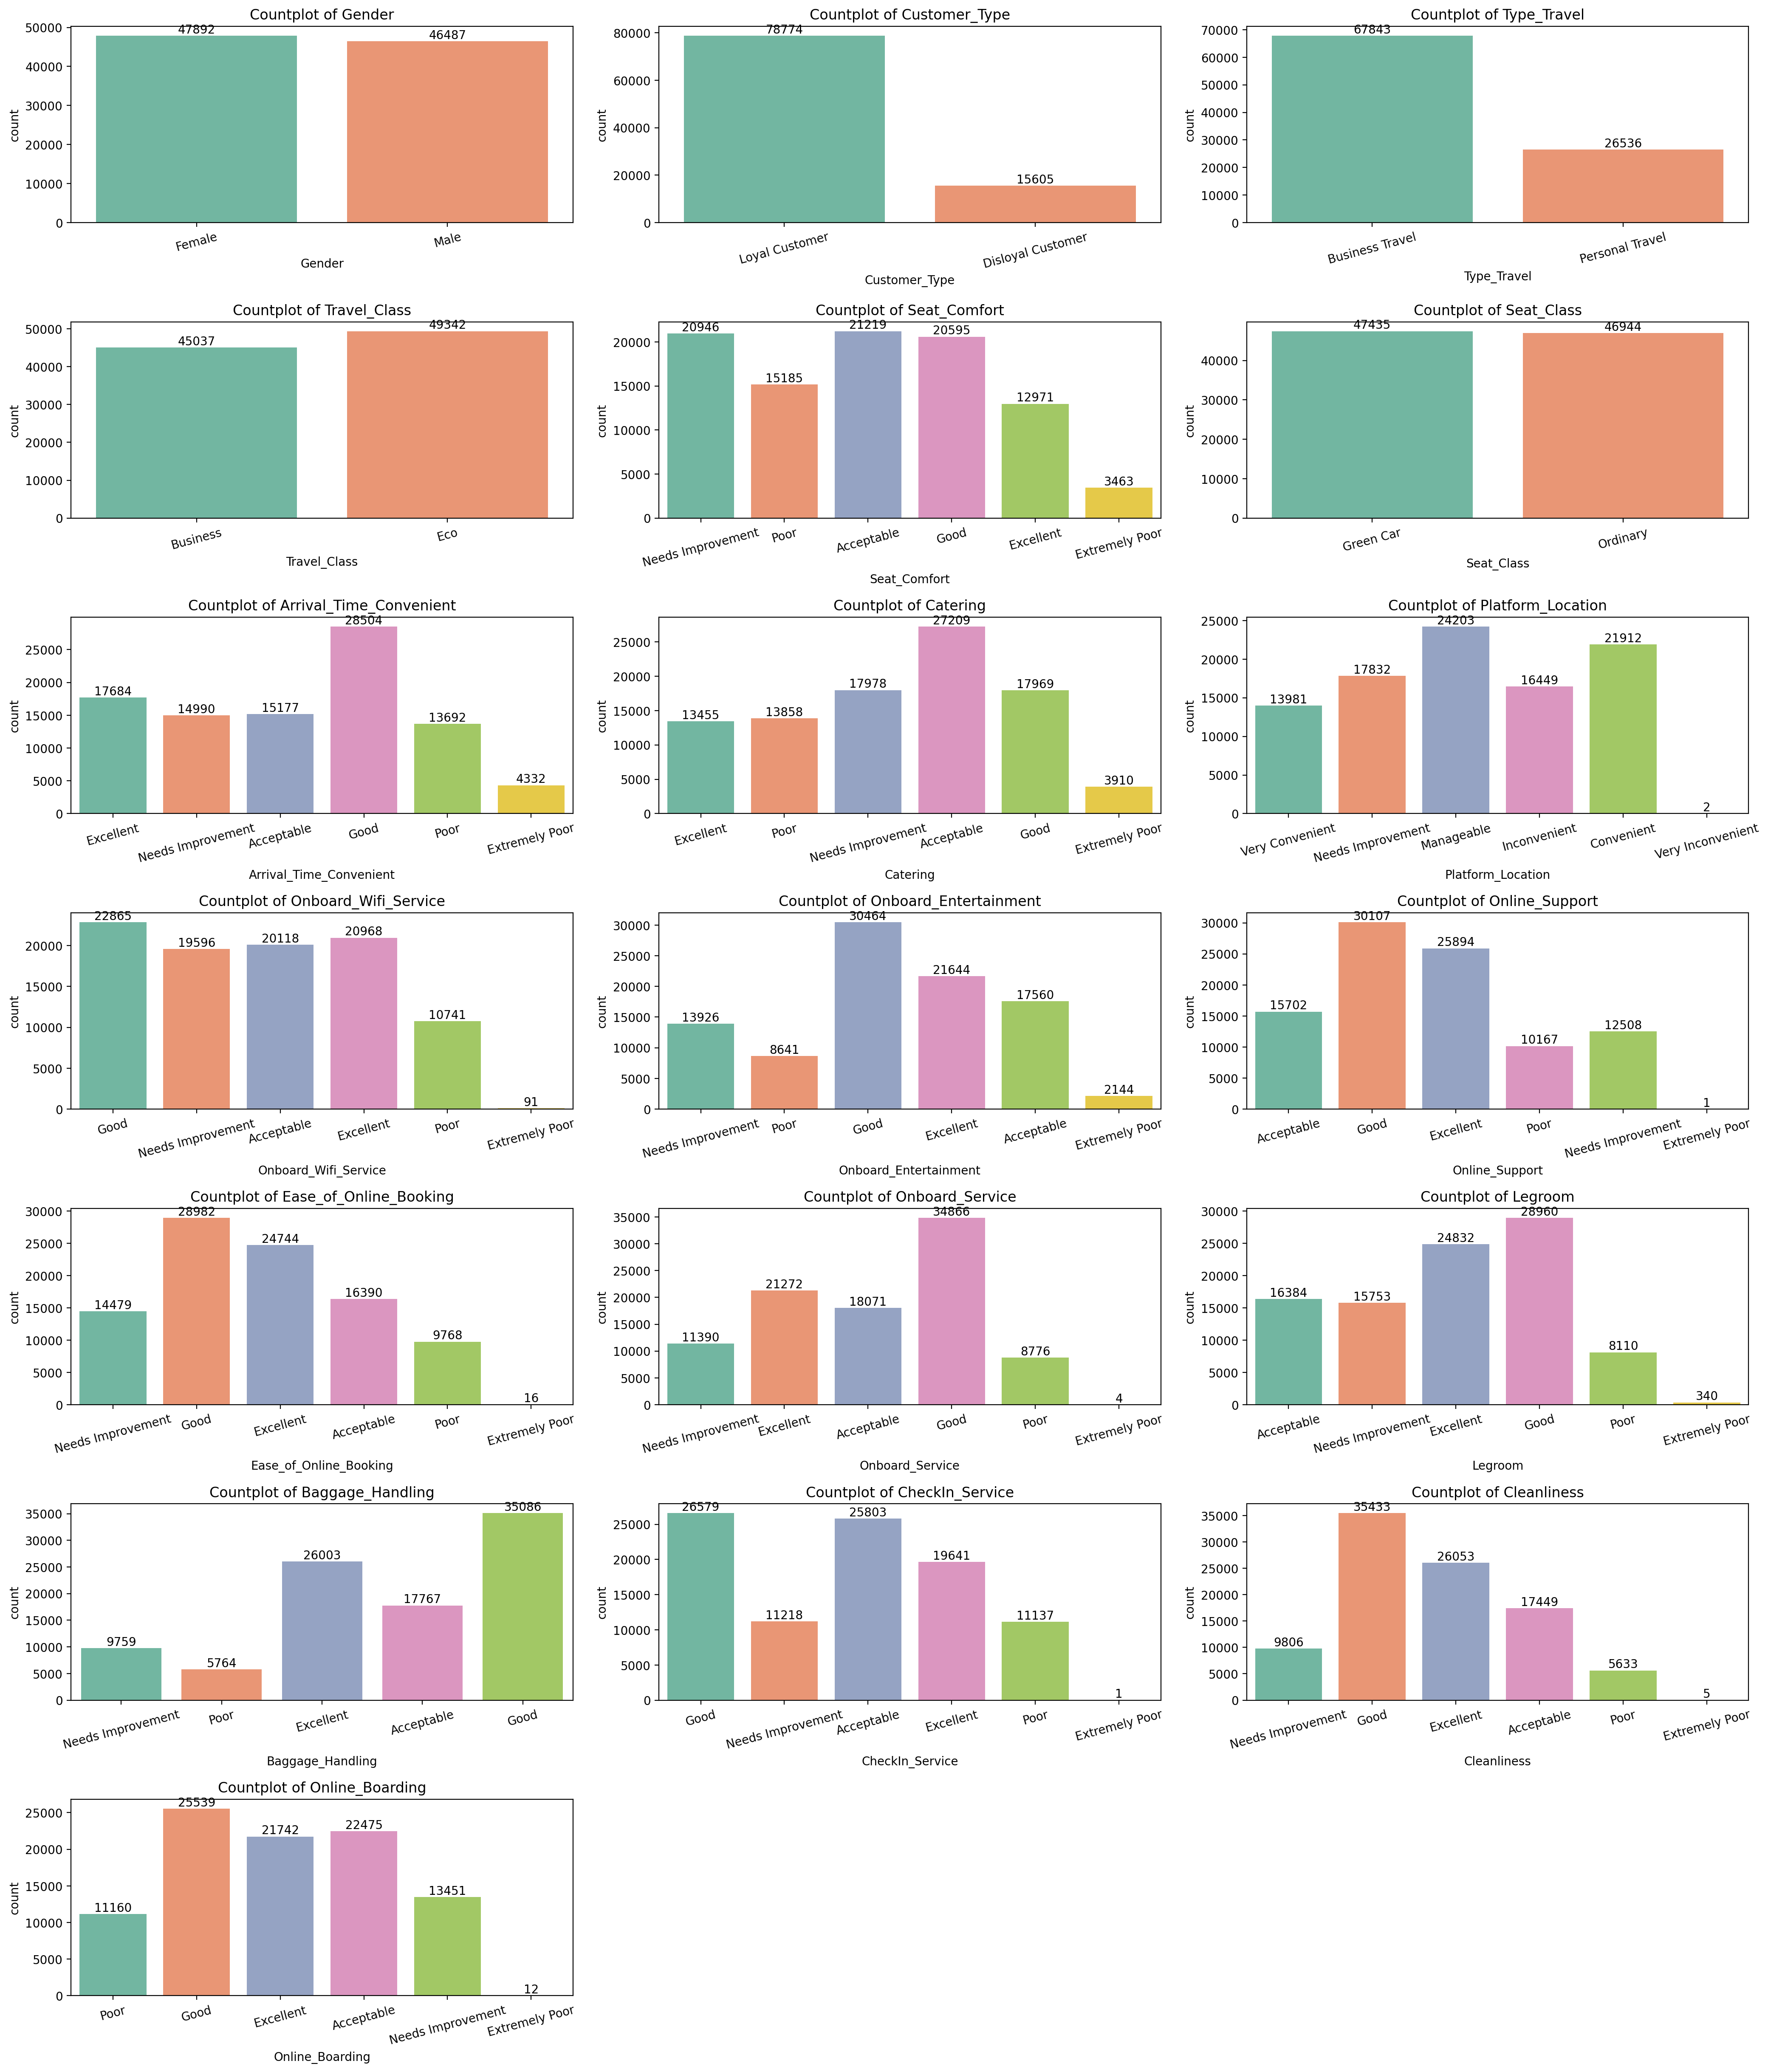

In [ ]:
# Create countplot for each categorical column
n = len(category_col)
# Set the number of columns in the grid
ncols = 3
# Calculate the number of rows needed
nrows = n // ncols + (n % ncols > 0)

# Adjust the figure size
plt.figure(figsize=(21, 3.5 * nrows))

# Loop through all categorical columns
for i, col in enumerate(category_col, 1):
  # Create a subplot for each categorical variable
  plt.subplot(nrows, ncols, i)
  ax = sns.countplot(data=train_no_dummy, x=col, hue=col, palette='Set2')
  plt.title(f'Countplot of {col}')
  plt.xticks(rotation=15)
  for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

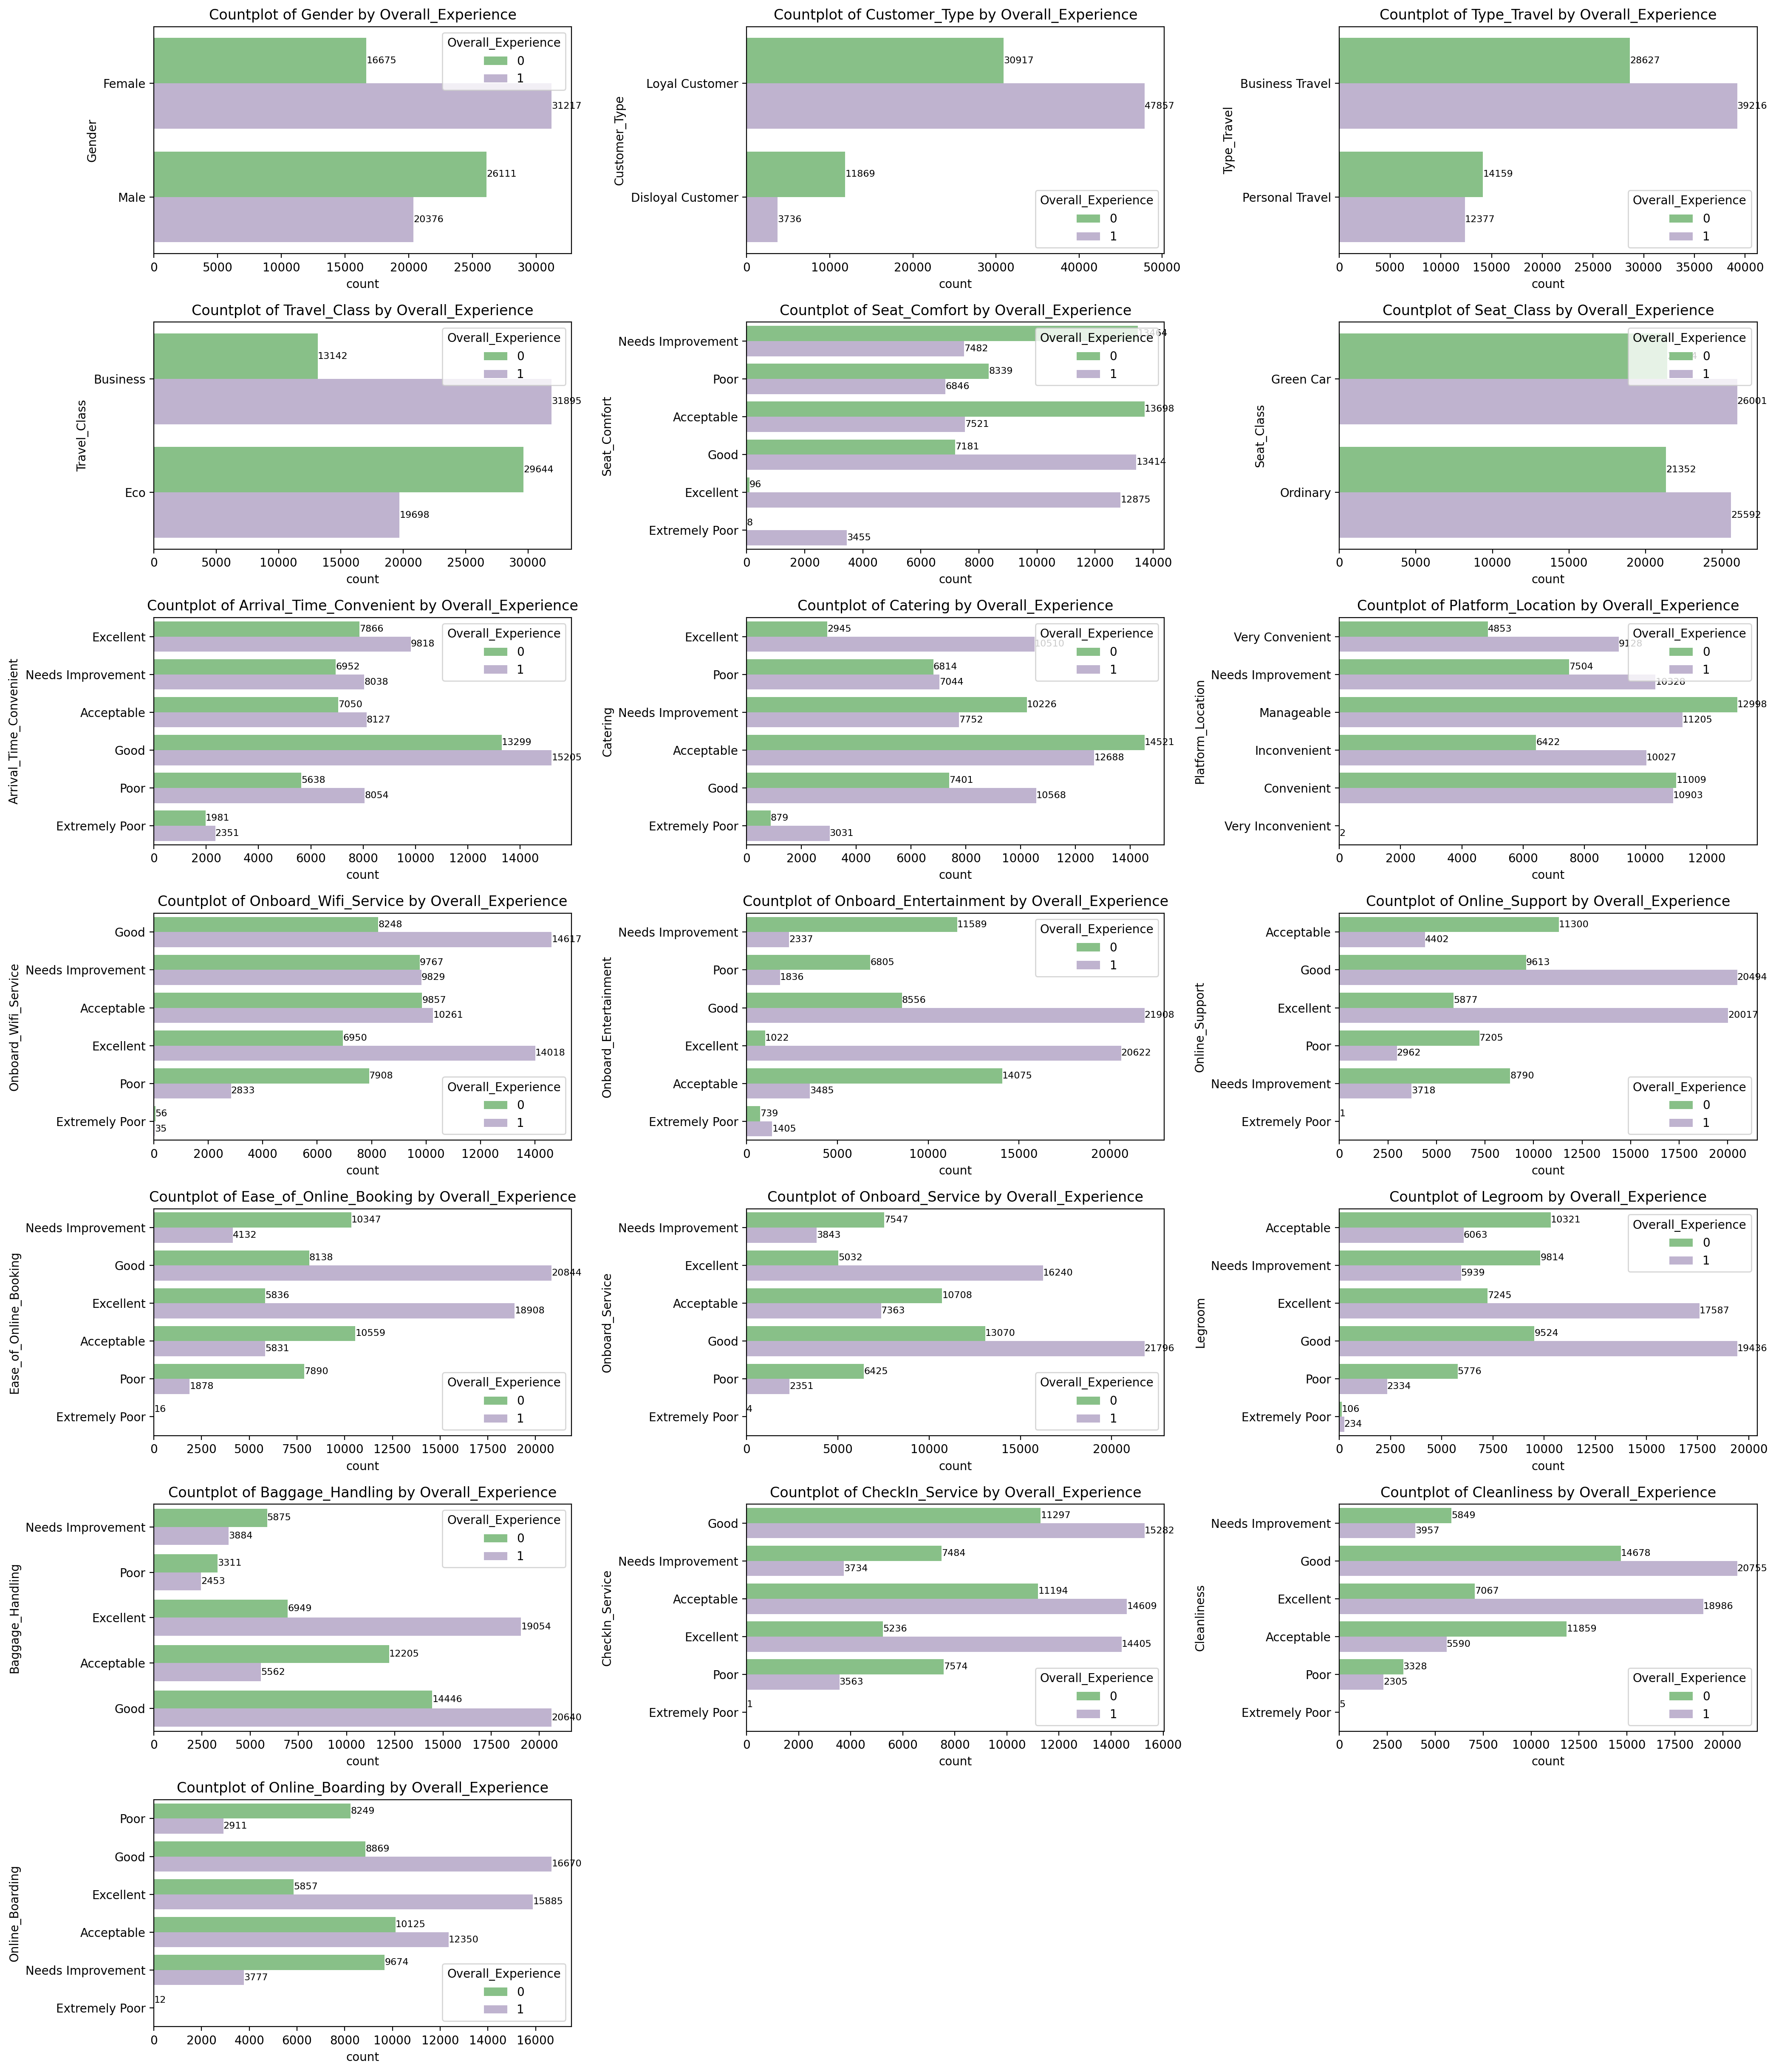

In [ ]:
# Create countplot for each categorical column, by Overall_Experience
# Adjust the figure size
plt.figure(figsize=(21, 3.5 * nrows))

# Loop through all categorical columns
for i, col in enumerate(category_col, 1):
  # Create a subplot for each categorical variable
  plt.subplot(nrows, ncols, i)
  ax = sns.countplot(data=train_no_dummy, y=col, hue='Overall_Experience', palette='Accent')
  plt.title(f'Countplot of {col} by Overall_Experience')
  for container in ax.containers:
    ax.bar_label(container,fontsize=8)

plt.tight_layout()
plt.show()

**Findings:**

- Although the number of males is slightly less than females, the males with unsatisfactory experience are much more than females.
- There are more loyal passengers than disloyal ones in this dataset (83.5% vs 16.5%). Meanwhile, the proportion of disloyal passengers with unsatisfactory experience is much higher than loyal passengers (76.1% vs 39.2%).
- More passengers in the dataset are traveling for business. The proportion of passengers traveling for business with unsatisfactory experience is lower than passengers traveling for personal purposes.
- Passengers in business class are more likely to have a satisfactory experience, compared to those in economic class.
- In this dataset, the number of passengers sitting in Green Car seats is very close to passengers sitting in ordinary seats. Meanwhile, the proportions of passengers' satisfaction in both seats are very close.


Next, it is helpful to learn about the correlations of several categorical features, such as:
- Gender vs Customer_Type, Type_Travel, Travel_Class, and Seat_Class.
- Customer_Type vs Type_Travel, Travel_Class, and Seat_Class.
- Type Travel vs Travel_Class and Seat_Class.
- Travel_Class vs Seat_Class.

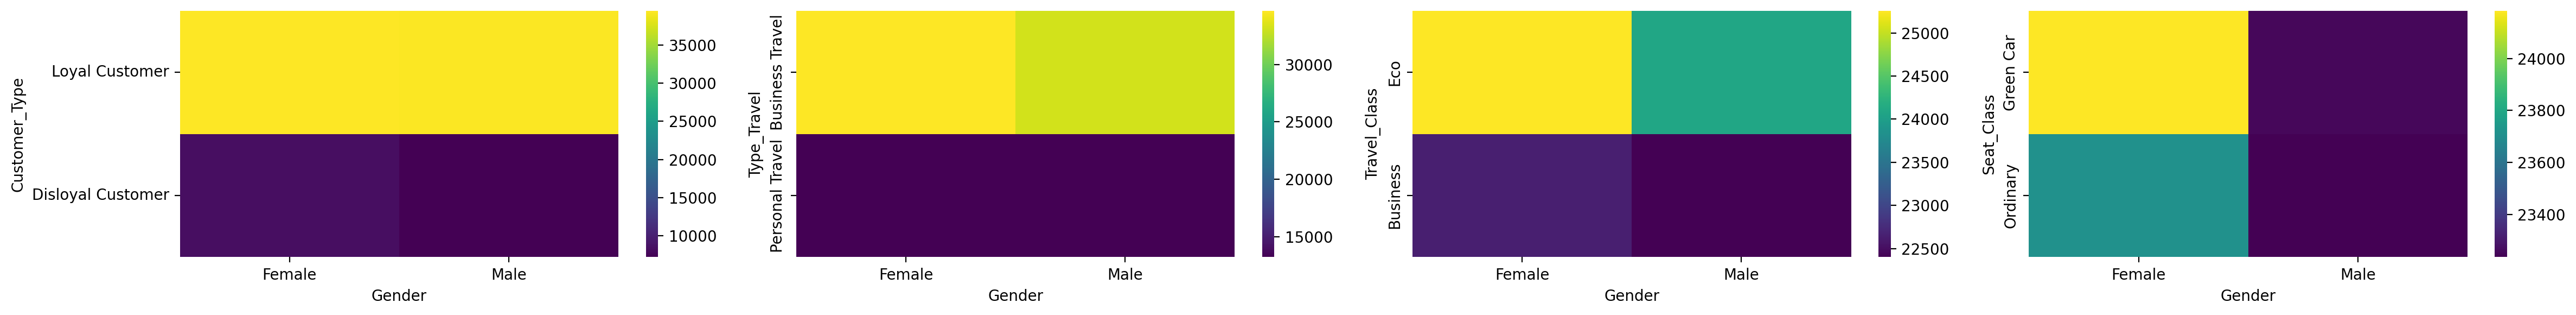

In [ ]:
# Gender vs Customer_Type, Type_Travel, Travel_Class, and Seat_Class
# List the features of interest
temp_features = ['Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Class']
# Adjust the figure size
plt.figure(figsize=(24, 3))

# Loop through temp_features list to visualize their relationships with Gender
for i, col in enumerate(temp_features, 1):
  plt.subplot(1, 4, i)
  df_2dhist = pd.DataFrame({
      x_label: grp[col].value_counts()
      for x_label, grp in train_no_dummy.groupby('Gender')
      })
  sns.heatmap(df_2dhist, cmap='viridis')
  plt.xlabel('Gender')
  _ = plt.ylabel(col)

plt.tight_layout()
plt.show()

There are no significant differences in the distributions of customer type, travel type, travel class and seat class between males and females.

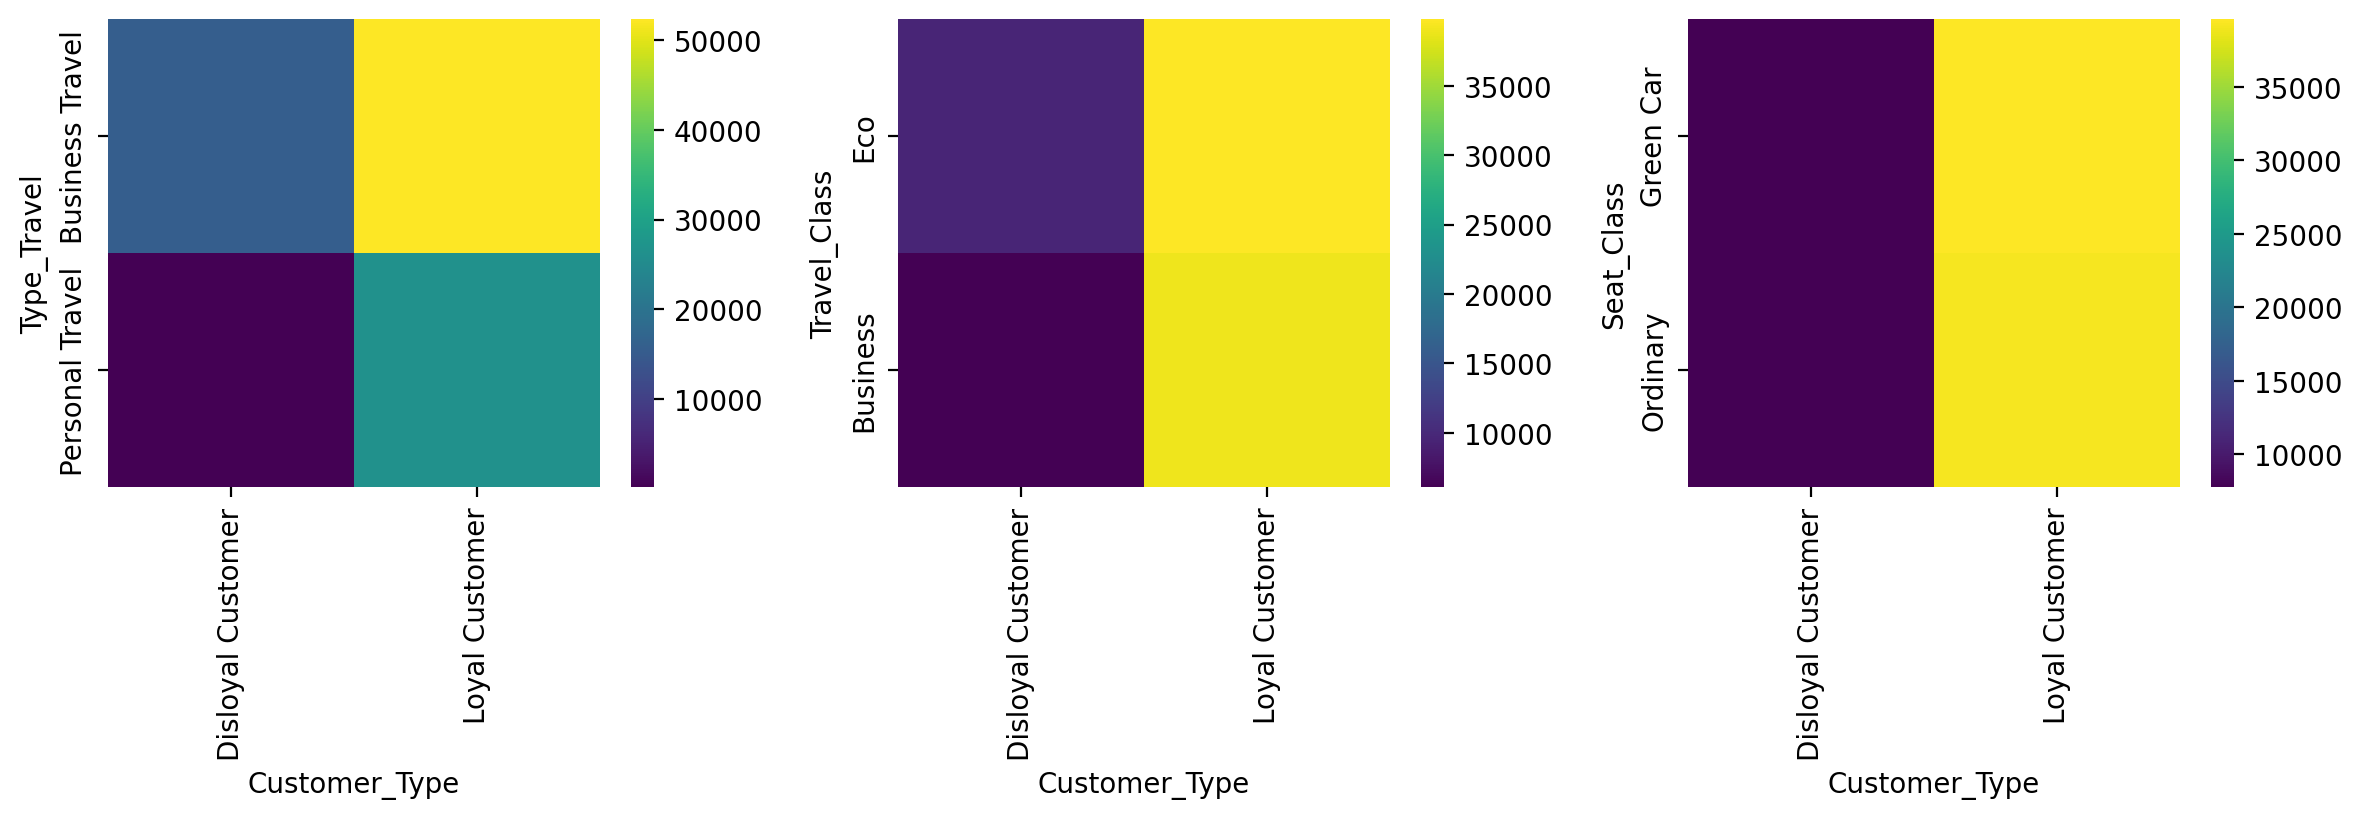

In [ ]:
# Customer_Type vs Type_Travel, Travel_Class, and Seat_Class
# Adjust the figure size
plt.figure(figsize=(12, 4.2))

# Loop through temp_features list to visualize their relationships with Gender
for i, col in enumerate(temp_features[1:], 1):
  plt.subplot(1, 3, i)
  df_2dhist = pd.DataFrame({
      x_label: grp[col].value_counts()
      for x_label, grp in train_no_dummy.groupby('Customer_Type')
      })
  sns.heatmap(df_2dhist, cmap='viridis')
  plt.xlabel('Customer_Type')
  _ = plt.ylabel(col)

plt.tight_layout()
plt.show()

There are no significant differences in the distributions of travel type, travel class and seat class between loyal and disloyal customers.

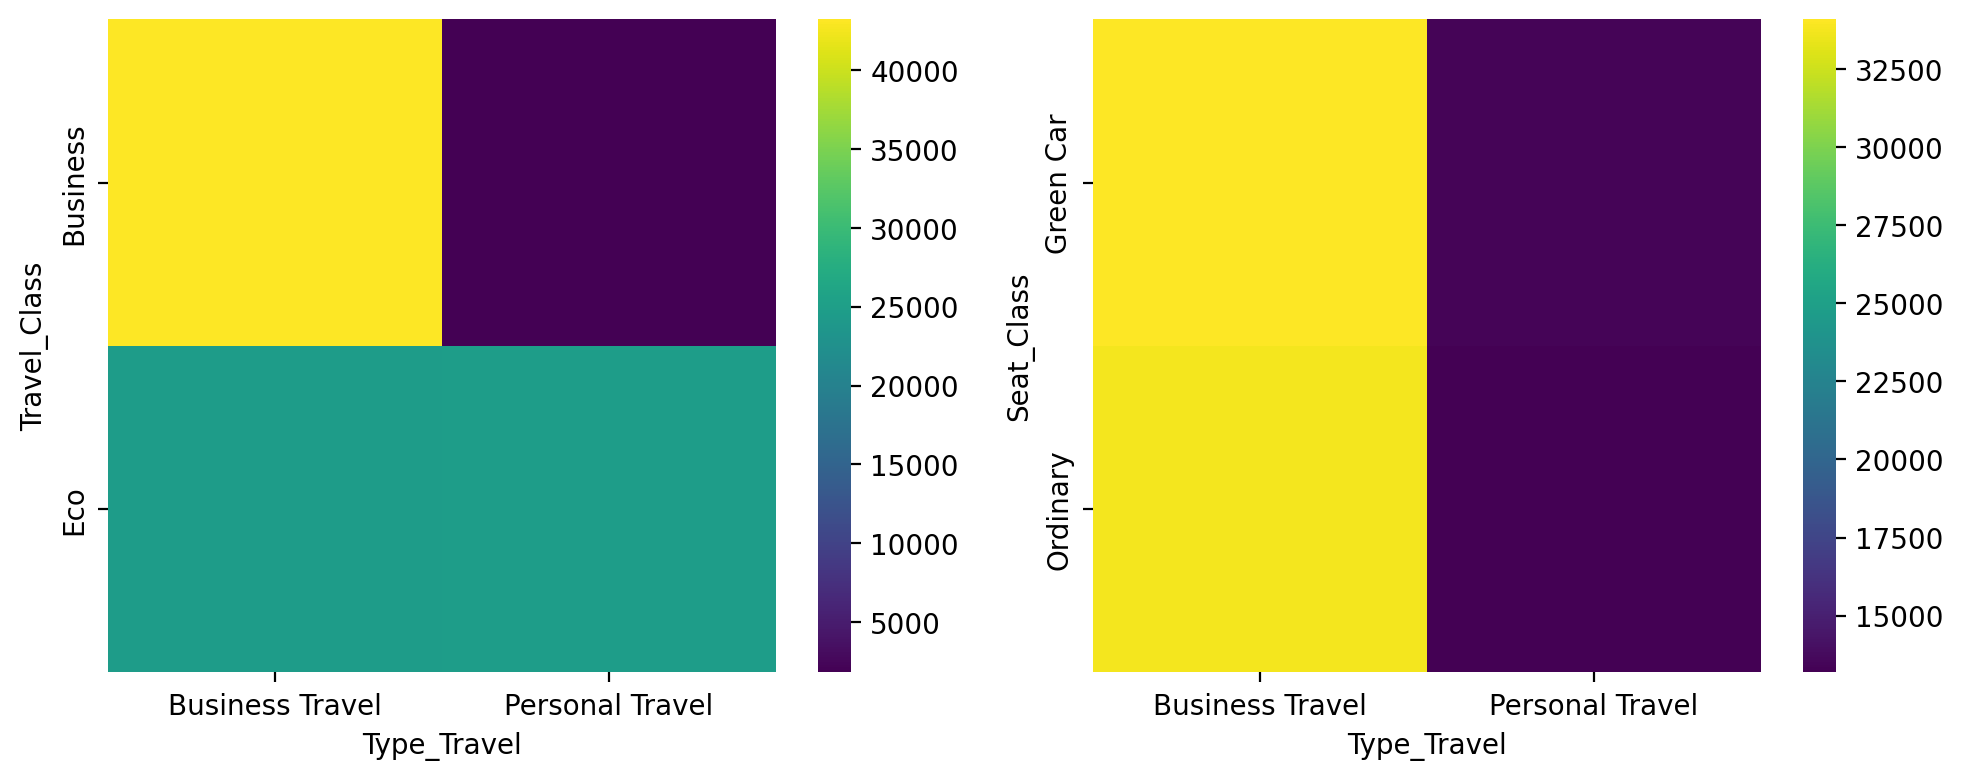

In [ ]:
# Type Travel vs Travel_Class and Seat_Class
# Adjust the figure size
plt.figure(figsize=(10, 4))

# Loop through temp_features list to visualize their relationships with Gender
for i, col in enumerate(temp_features[2:], 1):
  plt.subplot(1, 2, i)
  df_2dhist = pd.DataFrame({
      x_label: grp[col].value_counts()
      for x_label, grp in train_no_dummy.groupby('Type_Travel')
      })
  sns.heatmap(df_2dhist, cmap='viridis')
  plt.xlabel('Type_Travel')
  _ = plt.ylabel(col)

plt.tight_layout()
plt.show()

Consistent with common sense, passengers travelling for business are more likely to choose business travel class. However, travel type does not affect the choice of seat class too much.

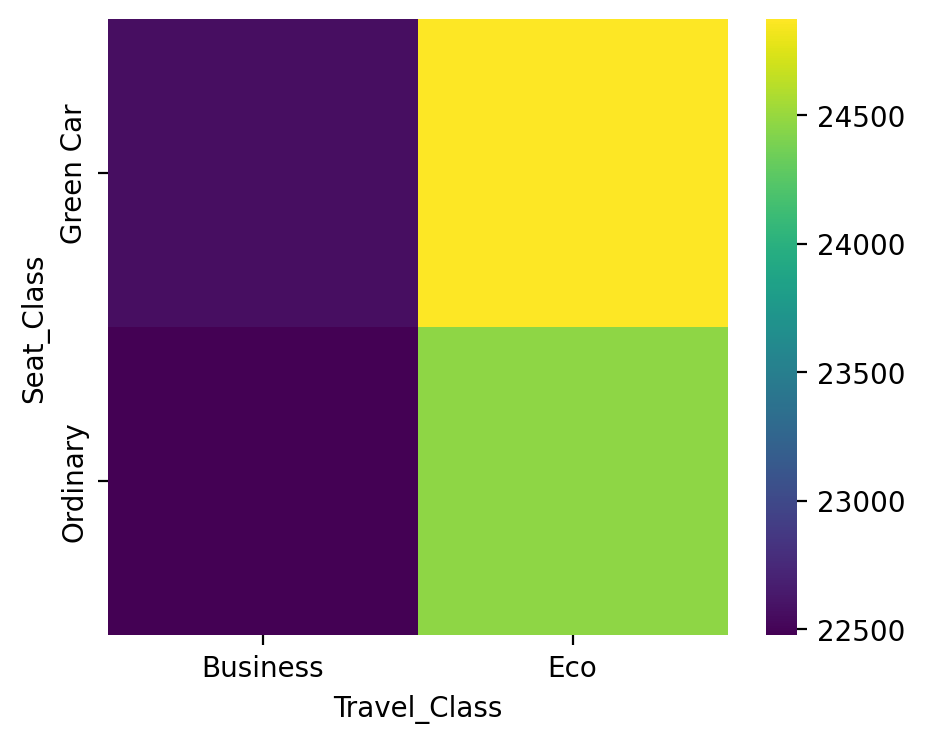

In [ ]:
# Travel_Class vs Seat_Class
# Adjust the figure size
plt.figure(figsize=(5, 4))

# Generate DataFrame for plotting
df_2dhist = pd.DataFrame({
    x_label: grp['Seat_Class'].value_counts()
    for x_label, grp in train_no_dummy.groupby('Travel_Class')
    })
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Travel_Class')
_ = plt.ylabel(col)

There are no significant differences in the distributions of travel type, travel class and seat class between passengers in green car seats and in ordinary seats.

## Train Models

In this section, we will train several models, including LightGBM, XGBoost, and Random Forest, and compare the accuracy of these models. Next, we will pick the one with the highest accuracy, and visualize the importances of features in the best-performed model.

In [ ]:
# Replace space within column names to underscore
train.columns = [sub.replace(' ', '_') for sub in train.columns]

In [ ]:
# Define X and y
X = train.drop(['Overall_Experience'],axis=1)
y = train['Overall_Experience']

In [ ]:
# Split the dataset into training and testing sets with 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### LightGBM

In [ ]:
# Train a LightGBM classifier for binary classification, evaluating its performance on the test set using log loss.
clf = lgbm.LGBMClassifier(objective="binary", n_estimators=10000)
eval_set = [(X_test, y_test)]
clf.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric="binary_logloss"
)

[LightGBM] [Info] Number of positive: 41307, number of negative: 34196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 75503, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547091 -> initscore=0.188923
[LightGBM] [Info] Start training from score 0.188923


LGBMClassifier(n_estimators=10000, objective='binary')

In [ ]:
# Generate probability predictions for the test set using the trained LightGBM model
preds = clf.predict_proba(X_test)
# Calculate and print the log loss of LightGBM predictions
print(f"LightGBM logloss on the evaluation set: {log_loss(y_test, preds):.5f}")

LightGBM logloss on the evaluation set: 0.24194


In [ ]:
# Predict class labels for the test set using the trained LightGBM classifier
class_lgbm = clf.predict(X_test)
print(f"LightGBM accuracy on the evaluation set: {accuracy_score(y_test, class_lgbm):.5f}")

LightGBM accuracy on the evaluation set: 0.95444


In [ ]:
'''
fit_params={"eval_metric" : 'auc',
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'categorical_feature': 'auto'}

param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100

# Perform hyperparameter tuning on LightGBM classifier using RandomizedSearchCV with ROC AUC as the scoring metric.
clf_tune = lgbm.LGBMClassifier(max_depth=-1, silent=True, n_estimators=12000,objective="binary")
gs = RandomizedSearchCV(
    estimator=clf_tune, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)
# Print the best-scored parameters
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
'''

'\nfit_params={"eval_metric" : \'auc\',\n            "eval_set" : [(X_test,y_test)],\n            \'eval_names\': [\'valid\'],\n            #\'callbacks\': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],\n            \'categorical_feature\': \'auto\'}\n\nparam_test ={\'num_leaves\': sp_randint(6, 50),\n             \'min_child_samples\': sp_randint(100, 500),\n             \'min_child_weight\': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],\n             \'subsample\': sp_uniform(loc=0.2, scale=0.8),\n             \'colsample_bytree\': sp_uniform(loc=0.4, scale=0.6),\n             \'reg_alpha\': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],\n             \'reg_lambda\': [0, 1e-1, 1, 5, 10, 20, 50, 100]}\n\nn_HP_points_to_test = 100\n\n# Perform hyperparameter tuning on LightGBM classifier using RandomizedSearchCV with ROC AUC as the scoring metric.\nclf_tune = lgbm.LGBMClassifier(max_depth=-1, silent=True, n_estimators=12000,objective="binary")\ngs = RandomizedSearchCV(

#### XGBoost

In [ ]:
# Initialize XGBoost classifier with specified configurations for binary classification
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=1121218,
    n_estimators=10000,
    tree_method="hist",  # enable histogram binning in XGB
)

# Fit the model on training data with evaluation on test set
xgb_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="logloss",
    early_stopping_rounds=150,
    verbose=False,  # Disable logs
)

# Predict probabilities on the test set to evaluate the final model performance
preds_xgb = xgb_clf.predict_proba(X_test)
# Calculate and display the log loss of XGBoost predictions
print(f"XGBoost logloss on the evaluation set: {log_loss(y_test, preds_xgb):.5f}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost logloss on the evaluation set: 0.10684


In [ ]:
# Predict class labels for the test set using the trained XGBoost model
class_xgb = xgb_clf.predict(X_test)
print(f"XGBoost accuracy on the evaluation set: {accuracy_score(y_test, class_xgb):.5f}")

XGBoost accuracy on the evaluation set: 0.95343


#### Random Forest

In [ ]:
# Initialize RandomForestClassifier with 1000 trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
# Predict probabilities on the test set to evaluate the final model performance
preds_rf = rf.predict_proba(X_test)
print(f"Random Forest logloss on the evaluation set: {log_loss(y_test, preds_rf):.5f}")

Random Forest logloss on the evaluation set: 0.13379


In [ ]:
# Predict class labels for the test set using the trained RandomForest model
class_rf = rf.predict(X_test)
print(f"Random Forest accuracy on the evaluation set: {accuracy_score(y_test, class_rf):.5f}")

Random Forest accuracy on the evaluation set: 0.95417


In [ ]:
'''
from scipy.stats import randint
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
'''

"\nfrom scipy.stats import randint\nparam_dist = {'n_estimators': randint(50,500),\n              'max_depth': randint(1,20)}\n\n# Create a random forest classifier\nrf = RandomForestClassifier()\n\n# Use random search to find the best hyperparameters\nrand_search = RandomizedSearchCV(rf,\n                                 param_distributions = param_dist,\n                                 n_iter=5,\n                                 cv=5)\n\n# Fit the random search object to the data\nrand_search.fit(X_train, y_train)\n\nbest_rf = rand_search.best_estimator_\n\n# Print the best hyperparameters\nprint('Best hyperparameters:',  rand_search.best_params_)\n"

In [ ]:
'''
# Generate predictions with the best model
best_rf_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, best_rf_pred)
precision = precision_score(y_test, best_rf_pred)
recall = recall_score(y_test, best_rf_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
'''

'\n# Generate predictions with the best model\nbest_rf_pred = best_rf.predict(X_test)\naccuracy = accuracy_score(y_test, best_rf_pred)\nprecision = precision_score(y_test, best_rf_pred)\nrecall = recall_score(y_test, best_rf_pred)\n\nprint("Accuracy:", accuracy)\nprint("Precision:", precision)\nprint("Recall:", recall)\n'

In [ ]:
'''
rf_train_pred = best_rf.predict(X_train)
accuracy_score(y_train, rf_train_pred)
'''

'\nrf_train_pred = best_rf.predict(X_train)\naccuracy_score(y_train, rf_train_pred)\n'

LightGBM model gave the best accuracy. Therefore, we willl use it to create prediction on test data for submission.

## Feature Importance Visualization

In this section, we will visualize the importance of features in LightGBM model, which performed best among all three candidate models.

In [ ]:
# Obtain the feature importance scores in the trained LightGBM model using split as the importance type
feature_importances = clf.feature_importances_
feature_names = clf.feature_name_

In [ ]:
# Create a pandas DataFrame to store the importance scores for easier manipulation
df_feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Select the top 20 features
top_20_features = df_feature_importances.head(20)

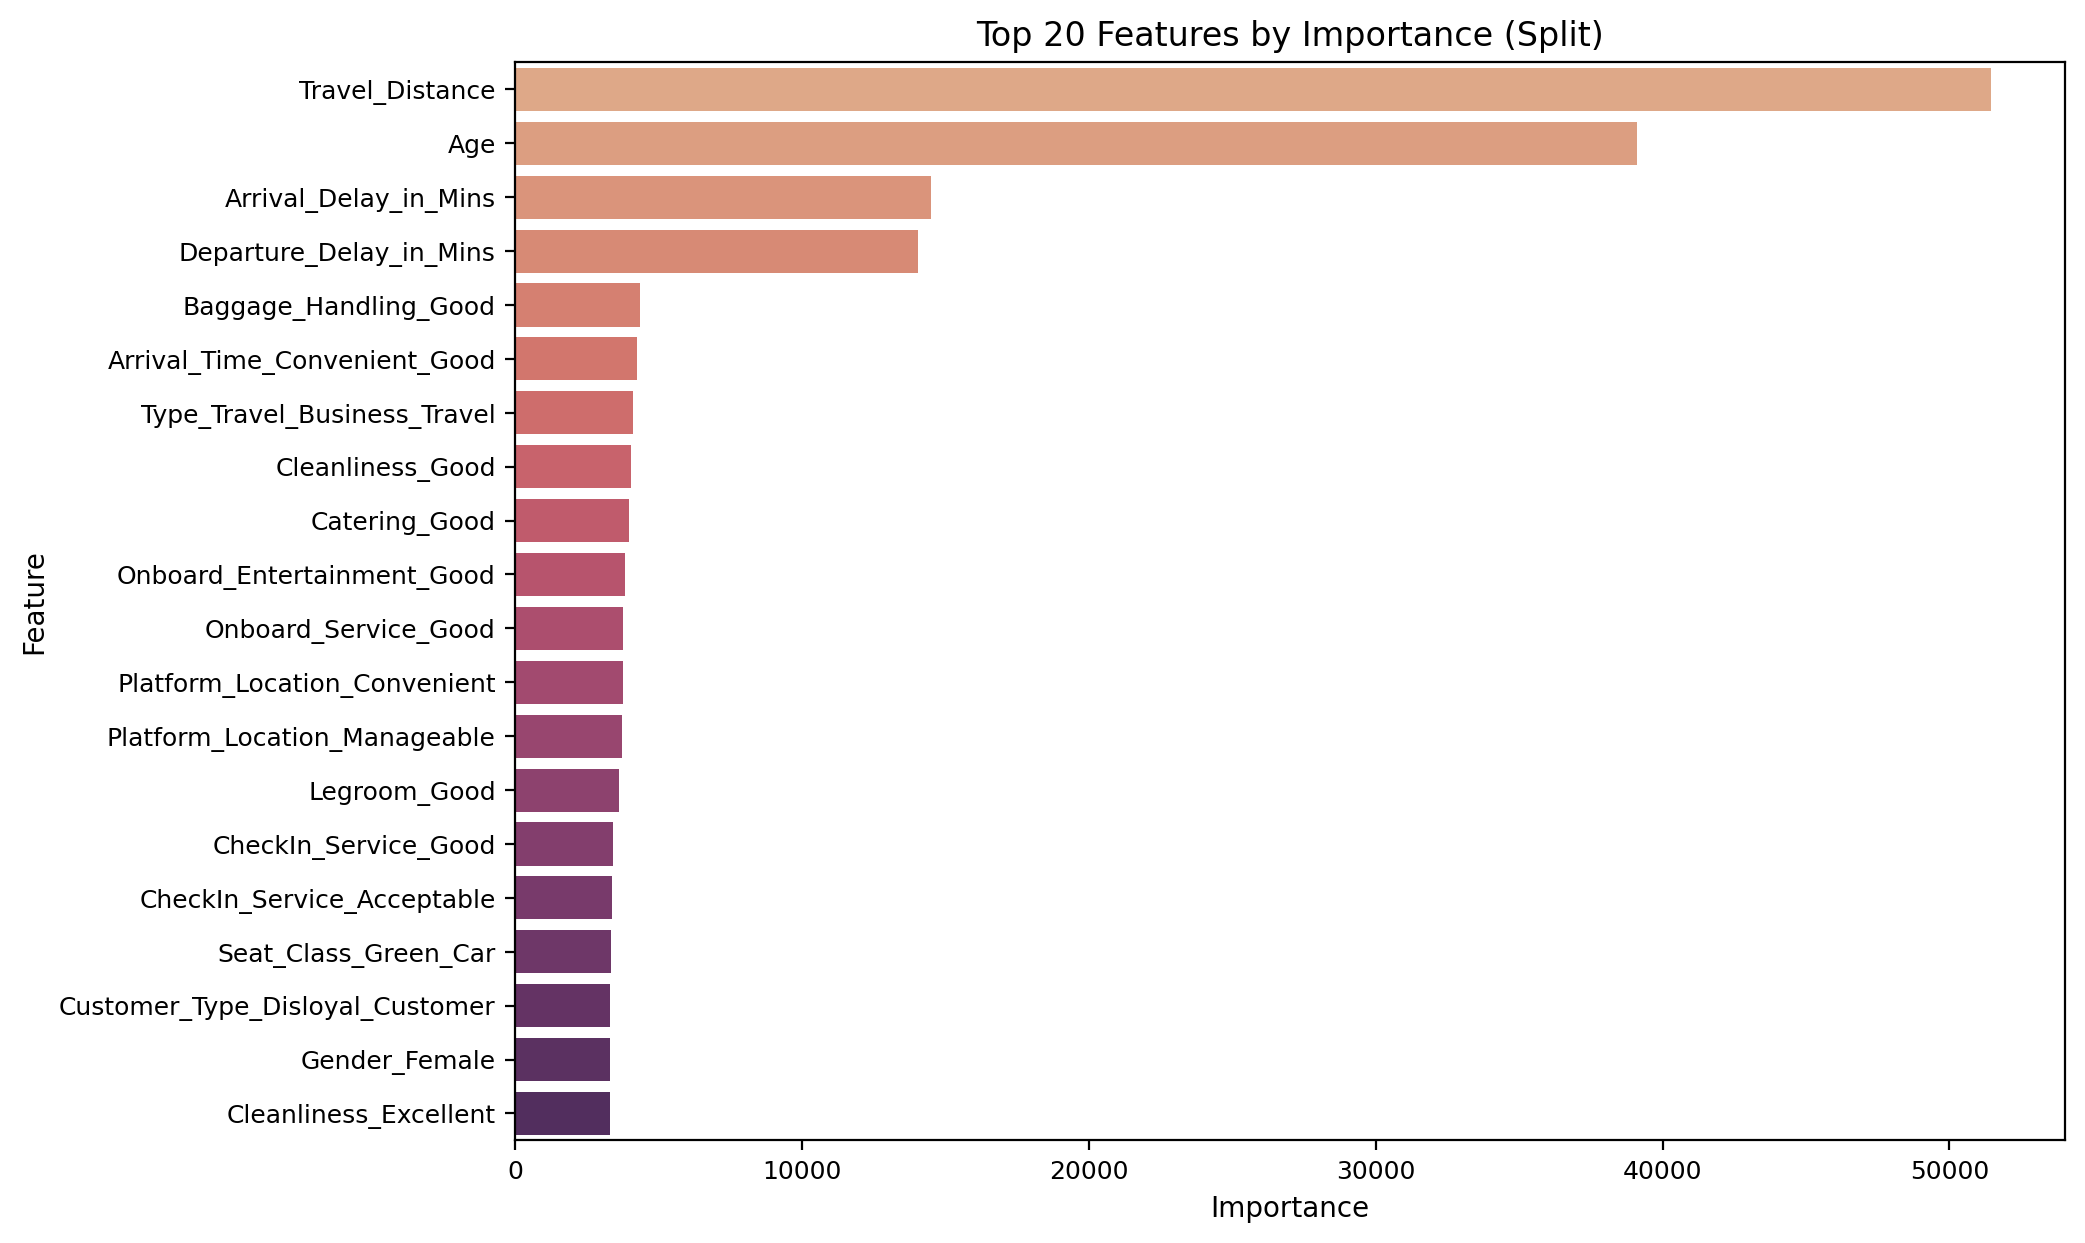

In [ ]:
# Plot feature importance using Gain
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', hue='feature', data=top_20_features, palette='flare', legend=False)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Top 20 Features by Importance (Split)')

# Show the plot
plt.show()

## Clean Test Data

In [ ]:
test_data_merged = pd.merge(travel_test, survey_test, on='ID')
test_data_merged.head()

ID  Gender      Customer_Type   Age      Type_Travel Travel_Class  \
0  99900001  Female                NaN  36.0  Business Travel     Business   
1  99900002  Female  Disloyal Customer  21.0  Business Travel     Business   
2  99900003    Male     Loyal Customer  60.0  Business Travel     Business   
3  99900004  Female     Loyal Customer  29.0  Personal Travel          Eco   
4  99900005    Male  Disloyal Customer  18.0  Business Travel     Business   

   Travel_Distance  Departure_Delay_in_Mins  Arrival_Delay_in_Mins  \
0              532                      0.0                    0.0   
1             1425                      9.0                   28.0   
2             2832                      0.0                    0.0   
3             1352                      0.0                    0.0   
4             1610                     17.0                    0.0   

     Seat_Comfort  ... Onboard_Wifi_Service Onboard_Entertainment  \
0      Acceptable  ...    Needs Improvement             Excellent   
1  Extremely Poor  ...           Acceptable                  Poor   
2       Excellent  ...            Excellent             Excellent   
3      Acceptable  ...                 Poor            Acceptable   
4       Excellent  ...            Excellent             Excellent   

  Online_Support Ease_of_Online_Booking    Onboard_Service            Legroom  \
0           Good              Excellent          Excellent          Excellent   
1     Acceptable             Acceptable          Excellent         Acceptable   
2      Excellent      Needs Improvement  Needs Improvement  Needs Improvement   
3      Excellent                   Poor         Acceptable  Needs Improvement   
4      Excellent              Excellent                NaN         Acceptable   

    Baggage_Handling CheckIn_Service        Cleanliness Online_Boarding  
0          Excellent            Good          Excellent            Poor  
1               Good      Acceptable          Excellent      Acceptable  
2  Needs Improvement            Good  Needs Improvement       Excellent  
3          Excellent       Excellent          Excellent            Poor  
4          Excellent       Excellent          Excellent       Excellent  

[5 rows x 24 columns]

In [ ]:
test_data = test_data_merged.copy(deep=True)

In [ ]:
for i in category_col:
  print("Column name: "+i)
  print("Most frequent value: "+train_data[i].mode()[0])
  test_data[i] = test_data[i].fillna(train_data[i].mode()[0])

Column name: Gender
Most frequent value: Female
Column name: Customer_Type
Most frequent value: Loyal Customer
Column name: Type_Travel
Most frequent value: Business Travel
Column name: Travel_Class
Most frequent value: Eco
Column name: Seat_Comfort
Most frequent value: Acceptable
Column name: Seat_Class
Most frequent value: Green Car
Column name: Arrival_Time_Convenient
Most frequent value: Good
Column name: Catering
Most frequent value: Acceptable
Column name: Platform_Location
Most frequent value: Manageable
Column name: Onboard_Wifi_Service
Most frequent value: Good
Column name: Onboard_Entertainment
Most frequent value: Good
Column name: Online_Support
Most frequent value: Good
Column name: Ease_of_Online_Booking
Most frequent value: Good
Column name: Onboard_Service
Most frequent value: Good
Column name: Legroom
Most frequent value: Good
Column name: Baggage_Handling
Most frequent value: Good
Column name: CheckIn_Service
Most frequent value: Good
Column name: Cleanliness
Most fre

In [ ]:
test_data['Age'] = test_data['Age'].fillna(train_data['Age'].median())

In [ ]:
test_data['Departure_Delay_in_Mins'] = test_data['Departure_Delay_in_Mins'].fillna(train_data['Departure_Delay_in_Mins'].median())
test_data['Arrival_Delay_in_Mins'] = test_data['Arrival_Delay_in_Mins'].fillna(train_data['Departure_Delay_in_Mins'])

In [ ]:
pd.concat([test_data.isnull().sum(),test_data.isnull().sum()/test_data.shape[0]*100],axis=1)

0    1
ID                       0  0.0
Gender                   0  0.0
Customer_Type            0  0.0
Age                      0  0.0
Type_Travel              0  0.0
Travel_Class             0  0.0
Travel_Distance          0  0.0
Departure_Delay_in_Mins  0  0.0
Arrival_Delay_in_Mins    0  0.0
Seat_Comfort             0  0.0
Seat_Class               0  0.0
Arrival_Time_Convenient  0  0.0
Catering                 0  0.0
Platform_Location        0  0.0
Onboard_Wifi_Service     0  0.0
Onboard_Entertainment    0  0.0
Online_Support           0  0.0
Ease_of_Online_Booking   0  0.0
Onboard_Service          0  0.0
Legroom                  0  0.0
Baggage_Handling         0  0.0
CheckIn_Service          0  0.0
Cleanliness              0  0.0
Online_Boarding          0  0.0

In [ ]:
test = test_data.set_index("ID")
test = pd.get_dummies(test, columns = category_col)
test.head()

Age  Travel_Distance  Departure_Delay_in_Mins  \
ID                                                         
99900001  36.0              532                      0.0   
99900002  21.0             1425                      9.0   
99900003  60.0             2832                      0.0   
99900004  29.0             1352                      0.0   
99900005  18.0             1610                     17.0   

          Arrival_Delay_in_Mins  Gender_Female  Gender_Male  \
ID                                                            
99900001                    0.0              1            0   
99900002                   28.0              1            0   
99900003                    0.0              0            1   
99900004                    0.0              1            0   
99900005                    0.0              0            1   

          Customer_Type_Disloyal Customer  Customer_Type_Loyal Customer  \
ID                                                                        
99900001                                0                             1   
99900002                                1                             0   
99900003                                0                             1   
99900004                                0                             1   
99900005                                1                             0   

          Type_Travel_Business Travel  Type_Travel_Personal Travel  ...  \
ID                                                                  ...   
99900001                            1                            0  ...   
99900002                            1                            0  ...   
99900003                            1                            0  ...   
99900004                            0                            1  ...   
99900005                            1                            0  ...   

          Cleanliness_Excellent  Cleanliness_Good  \
ID                                                  
99900001                      1                 0   
99900002                      1                 0   
99900003                      0                 0   
99900004                      1                 0   
99900005                      1                 0   

          Cleanliness_Needs Improvement  Cleanliness_Poor  \
ID                                                          
99900001                              0                 0   
99900002                              0                 0   
99900003                              1                 0   
99900004                              0                 0   
99900005                              0                 0   

          Online_Boarding_Acceptable  Online_Boarding_Excellent  \
ID                                                                
99900001                           0                          0   
99900002                           1                          0   
99900003                           0                          1   
99900004                           0                          0   
99900005                           0                          1   

          Online_Boarding_Extremely Poor  Online_Boarding_Good  \
ID                                                               
99900001                               0                     0   
99900002                               0                     0   
99900003                               0                     0   
99900004                               0                     0   
99900005                               0                     0   

          Online_Boarding_Needs Improvement  Online_Boarding_Poor  
ID                                                                 
99900001                                  0                     1  
99900002                                  0                     0  
99900003                                  0                     0  
99900004               

In [ ]:
# Replace space within column names to underscore
test.columns = [sub.replace(' ', '_') for sub in test.columns]

In [ ]:
test.columns

Index(['Age', 'Travel_Distance', 'Departure_Delay_in_Mins',
       'Arrival_Delay_in_Mins', 'Gender_Female', 'Gender_Male',
       'Customer_Type_Disloyal_Customer', 'Customer_Type_Loyal_Customer',
       'Type_Travel_Business_Travel', 'Type_Travel_Personal_Travel',
       'Travel_Class_Business', 'Travel_Class_Eco', 'Seat_Comfort_Acceptable',
       'Seat_Comfort_Excellent', 'Seat_Comfort_Extremely_Poor',
       'Seat_Comfort_Good', 'Seat_Comfort_Needs_Improvement',
       'Seat_Comfort_Poor', 'Seat_Class_Green_Car', 'Seat_Class_Ordinary',
       'Arrival_Time_Convenient_Acceptable',
       'Arrival_Time_Convenient_Excellent',
       'Arrival_Time_Convenient_Extremely_Poor',
       'Arrival_Time_Convenient_Good',
       'Arrival_Time_Convenient_Needs_Improvement',
       'Arrival_Time_Convenient_Poor', 'Catering_Acceptable',
       'Catering_Excellent', 'Catering_Extremely_Poor', 'Catering_Good',
       'Catering_Needs_Improvement', 'Catering_Poor',
       'Platform_Location_Convenien

In [ ]:
col_add = [a for a in list(X_train) if a not in list(test.columns)]

In [ ]:
for i in col_add:
  test[i]=np.uint8(0)
test = test[X_train.columns]

In [ ]:
len(test.columns)

97

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 99900001 to 99935602
Data columns (total 97 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        35602 non-null  float64
 1   Travel_Distance                            35602 non-null  int64  
 2   Departure_Delay_in_Mins                    35602 non-null  float64
 3   Arrival_Delay_in_Mins                      35602 non-null  float64
 4   Gender_Female                              35602 non-null  uint8  
 5   Gender_Male                                35602 non-null  uint8  
 6   Customer_Type_Disloyal_Customer            35602 non-null  uint8  
 7   Customer_Type_Loyal_Customer               35602 non-null  uint8  
 8   Type_Travel_Business_Travel                35602 non-null  uint8  
 9   Type_Travel_Personal_Travel                35602 non-null  uint8  
 10  Travel_Class

In [ ]:
#rf_test_pred = best_rf.predict(test)
#results = pd.DataFrame({'ID':list(test.index),'Overall_Experience': rf_test_pred})
#results.to_csv('results.csv',index=False)

In [ ]:
#xgb_clf_pred = xgb_clf.predict(test)
#pd.DataFrame({'ID':list(test.index),'Overall_Experience': xgb_clf_pred}).to_csv('results2.csv',index=False)

In [ ]:
# Predict the class label on the test dataset
lightgbm_clf_pred=clf.predict(test)

In [ ]:
# Write the predicted class label to .csv for submission
pd.DataFrame({'ID':list(test.index),'Overall_Experience': lightgbm_clf_pred}).to_csv('results3.csv',index=False)